# Imports and setup

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import cmasher as cmr
cmap=cmr.sunburst_r

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import importlib
import sys
sys.path.append('../../')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [29]:
# this file now automatically includes the cut on magnitude (on work desktop). Should fix this for minimal confusion later
data = at.Table.read("/Users/Tavangar/Work/gd1-dr3/data/GD1-region-alldata.fits")

pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

# run_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask)]
# bkg_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask) & ~iso_obj.on_skymask]
# stream_data_ = iso_obj.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask]

# post_cats = {'run_data': run_data_,
#          'bkg_data': bkg_data_,
#          'stream_data': stream_data_,
#          'pawprint': pawprint,
#          'iso_obj': iso_obj}
# with open('../../data/post_cats_data.pkl', 'wb') as param_file:
#     pickle.dump(post_cats, param_file)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.26720538330726), np.float64(-3.1634227867925135), np.float64(0.5151487185597746), np.float64(0.38624247171130377)] 

Producing the polygon and mask


/Users/Tavangar/Work/stream-membership/stream-env/lib/python3.12/site-packages/cats/CMD.py:293: RuntimeWarning: invalid value encountered in divide
  signal = signal / signal_counts


In [4]:
with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

(-300.0, 400.0)

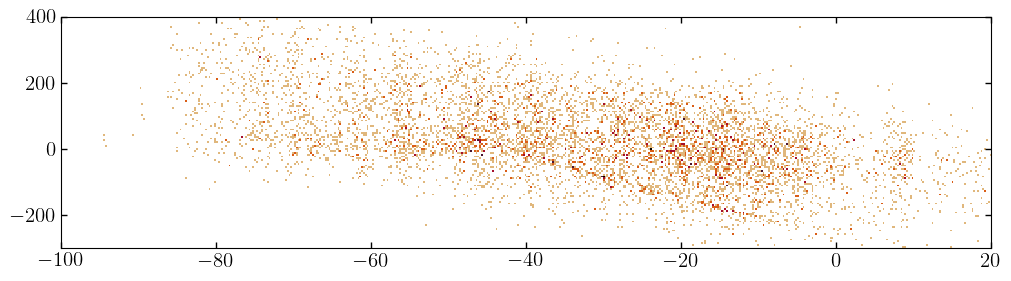

In [5]:
plt.figure(figsize=(12, 3))
plt.hist2d(run_data_['phi1'][run_data_['rv'] != 0], run_data_['rv'][run_data_['rv'] != 0], bins=[512, 128], range=[[-100, 20], [-300, 400]], cmap=cmap)
plt.ylim(-300, 400)

In [6]:
# Fill in rv data for rows without it (rv=0, rv_err=1e4)
run_data_['rv'][run_data_['rv'].mask] = 0
run_data_['rv_err'][run_data_['rv_err'].mask] = 1e4

bkg_data_['rv'][bkg_data_['rv'].mask] = 0
bkg_data_['rv_err'][bkg_data_['rv_err'].mask] = 1e4

stream_data_['rv'][stream_data_['rv'].mask] = 0
stream_data_['rv_err'][stream_data_['rv_err'].mask] = 1e4

In [7]:
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}#run_data_.colnames}
run_data_err = {'pm1': jnp.array(run_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(run_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(run_data_['rv_err'], dtype="f8")}

bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}#bkg_data_.colnames}
bkg_data_err = {'pm1': jnp.array(bkg_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(bkg_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(bkg_data_['rv_err'], dtype="f8")}

stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}#stream_data_.colnames}
stream_data_err = {'pm1': jnp.array(stream_data_['pm1_error'], dtype="f8"),
                   'pm2': jnp.array(stream_data_['pm2_error'], dtype="f8"),
                   'rv': jnp.array(stream_data_['rv_err'], dtype="f8")}

In [8]:
print(len(run_data_))

83735


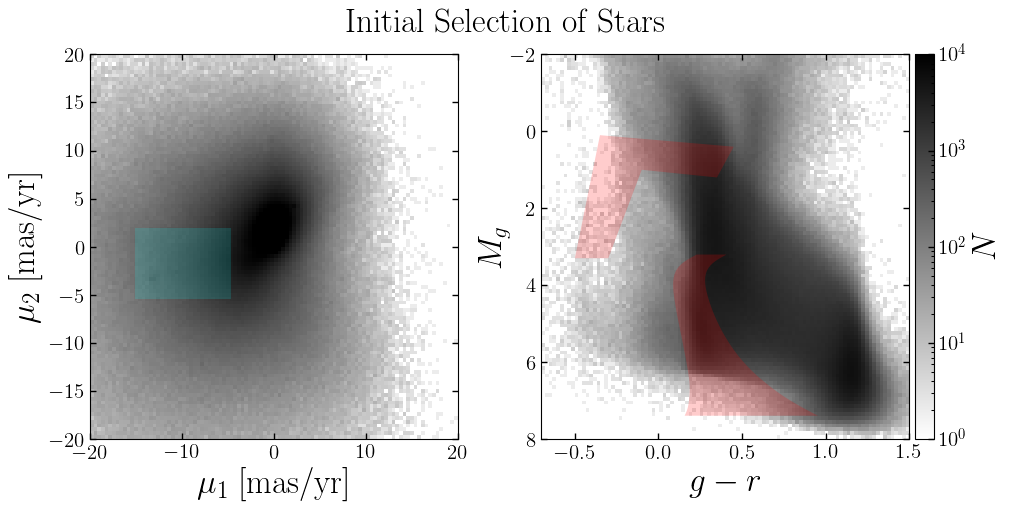

In [32]:
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
hb_poly = iso_obj.pawprint.hbprint.vertices - jnp.array([0,iso_obj.dist_mod])
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.2)

pm_poly = iso_obj.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, facecolor="cyan", alpha=0.15)

distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(iso_obj.cat["phi1"]) - iso_obj.dist_mod

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
im1 = ax1.hist2d(iso_obj.cat['pm1'], iso_obj.cat['pm2'], cmap='gray_r', bins=100, range=[[-20,20],[-20,20]], 
           norm=mpl.colors.LogNorm(vmax=1e4), rasterized=True)
# cbar1 = fig.colorbar(im1[3], ax=ax1, pad=-0.02)
ax1.add_patch(pm_patch)
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

im2 = ax2.hist2d(iso_obj.cat['g0'] - iso_obj.cat['r0'], iso_obj.cat['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
           bins=100, range=[[-0.7,1.5],[-2,8]], norm=mpl.colors.LogNorm(vmax=1e4), rasterized=True, cmap='gray_r')
cbar = fig.colorbar(im2[3], ax=ax2, pad=-0.02)
cbar.set_label(label=r'$N$', fontsize=24)
ax2.add_patch(cmd_patch)
ax2.add_patch(hb_patch)
ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(8, -2)

ax1.set_xlabel(r'$\mu_1$ [mas/yr]', fontsize=24)
ax1.set_ylabel(r'$\mu_2$ [mas/yr]', fontsize=24)

ax2.set_xlabel(r'$g-r$', fontsize=24)
ax2.set_ylabel(r'$M_g$', fontsize=24, labelpad=0.1)
fig.suptitle('Initial Selection of Stars', fontsize=24)
plt.savefig('../../paper_figures/gd1_cuts.pdf')
plt.show()

In [26]:
coord_bounds, plot_grids = init_stream.get_bounds_and_grids(run_data, pawprint)
    
phi1_lim = coord_bounds['phi1']
phi2_lim = coord_bounds['phi2']
pm1_lim  = coord_bounds['pm1']
pm2_lim  = coord_bounds['pm2']
rv_lim   = coord_bounds['rv']

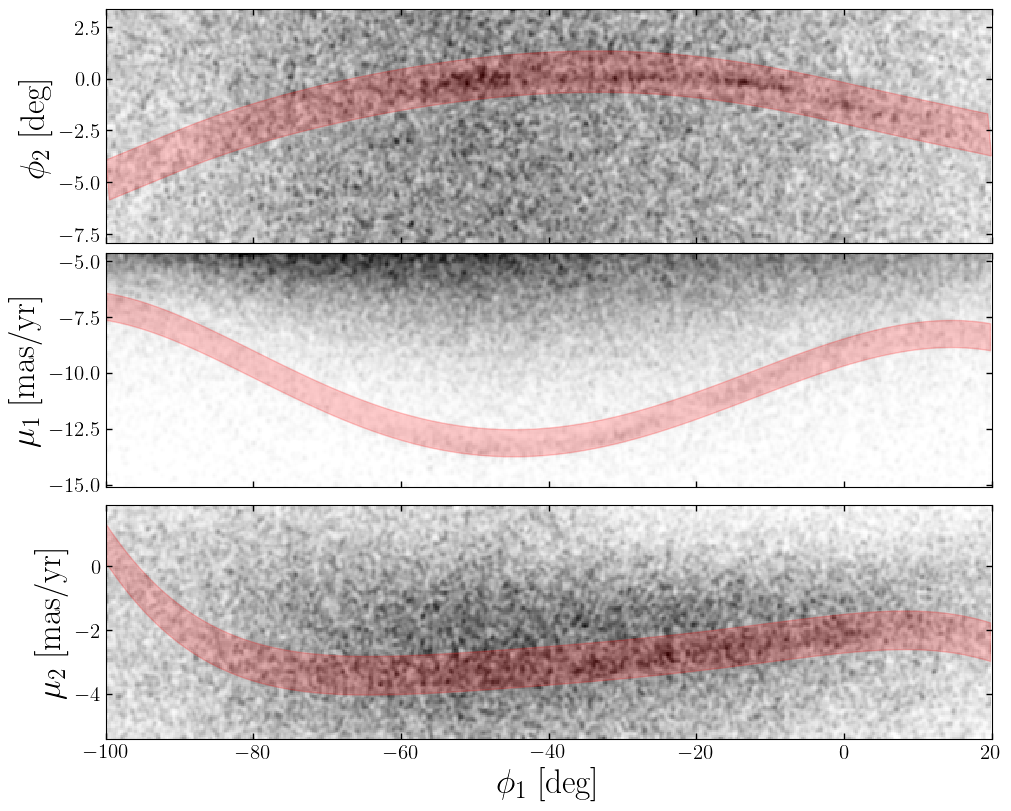

In [31]:
patch_sky = mpl.patches.Polygon(
            iso_obj.pawprint.skyprint["stream"].vertices[::50],
            facecolor="r",
            edgecolor="r",
            linewidth=1,
            alpha=0.2
        )

spline_phi2, spline_pm1, spline_pm2, _ = pmsel.from_galstreams()
# interp_dict = init_stream.interpolate_stream_tracks(stream_data_, phi1_lim)
# spline_phi2, spline_pm1, spline_pm2, spline_rv = interp_dict['phi2'], interp_dict['pm1'], interp_dict['pm2'], interp_dict['rv']

fig, axes, _ = plot_data_projections(data=run_data, grids=plot_grids, coord_names=[('phi1','phi2'), ('phi1','pm1'), ('phi1','pm2')],
                      smooth=1, pcolormesh_kwargs={'rasterized':True, 'cmap':'gray_r'});
axes[0].add_patch(patch_sky)
axes[0].set_ylabel(r'$\phi_2$ [deg]', fontsize=24)
phi1_array = jnp.arange(-100, 20, 0.2)
axes[1].fill_between(phi1_array, spline_pm1(phi1_array)+jnp.exp(-0.5), spline_pm1(phi1_array)-jnp.exp(-0.5), 
                     color='r', alpha=0.2)
axes[1].set_ylabel(r'$\mu_1$ [mas/yr]', fontsize=24)
axes[2].fill_between(phi1_array, spline_pm2(phi1_array)+jnp.exp(-0.5), spline_pm2(phi1_array)-jnp.exp(-0.5), 
                     color='r', alpha=0.2)
axes[2].set_xlabel(r'$\phi_1$ [deg]', fontsize=24)
axes[2].set_ylabel(r'$\mu_2$ [mas/yr]', fontsize=24)
axes[2].set_xlim(-100, 20)
# axes[1].add_patch(patch_pm1)
# axes[2].add_patch(patch_pm2)
plt.savefig('../../paper_figures/gd1_data.pdf')
plt.show()

# Background

In [12]:
importlib.reload(init_stream)

<module 'initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/scripts/initialize_stream.py'>

In [13]:
bkg_knot_spacings=[40,40,40,40]
n_mixture=2

bkg_model = init_stream.make_bkg_model_component(knot_spacings=bkg_knot_spacings, n_mixture=n_mixture, 
                                                 coord_bounds=coord_bounds, data=bkg_data)

In [14]:
n_phi1_knots = bkg_model.coord_parameters['phi1']['locs'].shape[-1]
n_pm1_knots = bkg_model.coord_parameters['pm1']['knots'].shape[-1]
n_pm2_knots = bkg_model.coord_parameters['pm2']['knots'].shape[-1]
n_rv_knots = bkg_model.coord_parameters['rv']['knots'].shape[-1]

bkg_init_params = {
        "phi1": {
            "mixing_distribution": jnp.ones(n_phi1_knots) / n_phi1_knots,
            "scales": jnp.full(n_phi1_knots, bkg_knot_spacings[0])
        },
        "phi2": {},
        "pm1": {
            "mixing_distribution": jnp.ones(n_mixture) / n_mixture,
            "loc_vals": jnp.full((n_mixture, n_pm1_knots), 0),
            "scale_vals": jnp.full((n_mixture, n_pm1_knots), 5.0),
        },
        "pm2": {
            "mixing_distribution": jnp.ones(n_mixture) / n_mixture,
            "loc_vals": jnp.full((n_mixture, n_pm2_knots), -3.0),
            "scale_vals": jnp.full((n_mixture, n_pm2_knots), 3.0),
        },
        "rv": {
            "mixing_distribution": jnp.ones(n_mixture) / n_mixture,
            "loc_vals": jnp.full((n_mixture, n_rv_knots), -100),
            "scale_vals": jnp.full((n_mixture,n_rv_knots), 50),
        },
    }

In [14]:
# _ = bkg_model.plot_model_projections(pars=bkg_init_params, grids=plot_grids, pcolormesh_kwargs=dict(rasterized=True))

In [16]:
keys = jax.random.split(jax.random.PRNGKey(42), num=2)
bkg_svi_results, bkg_guide = run_SVI(bkg_model, bkg_init_params, bkg_data, bkg_data_err,
                                     num_steps=1_000, GuideFunction=AutoNormal, keys=keys,
                                     init_lr=1e-2, adaptive_lr=True, num_particles=1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:55<00:00,  2.40it/s, init loss: 486003617.3669, avg. loss [951-1000]: 3284809.9658]


5000 steps to get to 1.43e6 with 10000 total steps, 3 particles, and init_lr=1e-2

In [15]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
bkg_filename = svi_results_dir + 'bkg_{}_{}_{}_{}.pkl'.format(*bkg_knot_spacings)
with open(bkg_filename, 'rb') as input_file_:
    bkg_dict = pickle.load(input_file_)
bkg_svi_results = bkg_dict['svi_results']
bkg_guide = bkg_dict['guide']

In [40]:
bkg_svi_results.params


{'background:phi1:mixing_distribution_auto_loc': Array([-0.21341878,  0.10896977,  1.85363587], dtype=float64),
 'background:phi1:mixing_distribution_auto_scale': Array([0.02786411, 0.01720085, 0.12090881], dtype=float64),
 'background:phi1:scales_auto_loc': Array([3.85362196, 2.82055875, 3.2600386 , 3.81834417], dtype=float64),
 'background:phi1:scales_auto_scale': Array([0.01965112, 0.01769105, 0.0138596 , 0.05516861], dtype=float64),
 'background:pm1:loc_vals_auto_loc': Array([[-1.10730324, -1.13768635, -1.1407678 , -1.14647226],
        [ 3.94864232,  0.09623862, -0.27357957,  2.95969576]],      dtype=float64),
 'background:pm1:loc_vals_auto_scale': Array([[0.00767072, 0.0027798 , 0.00325136, 0.01098156],
        [0.32162382, 0.01396357, 0.01454111, 0.21127966]], dtype=float64),
 'background:pm1:mixing_distribution_auto_loc': Array([-2.29782434], dtype=float64),
 'background:pm1:mixing_distribution_auto_scale': Array([0.02692258], dtype=float64),
 'background:pm1:modeldata_auto_loc

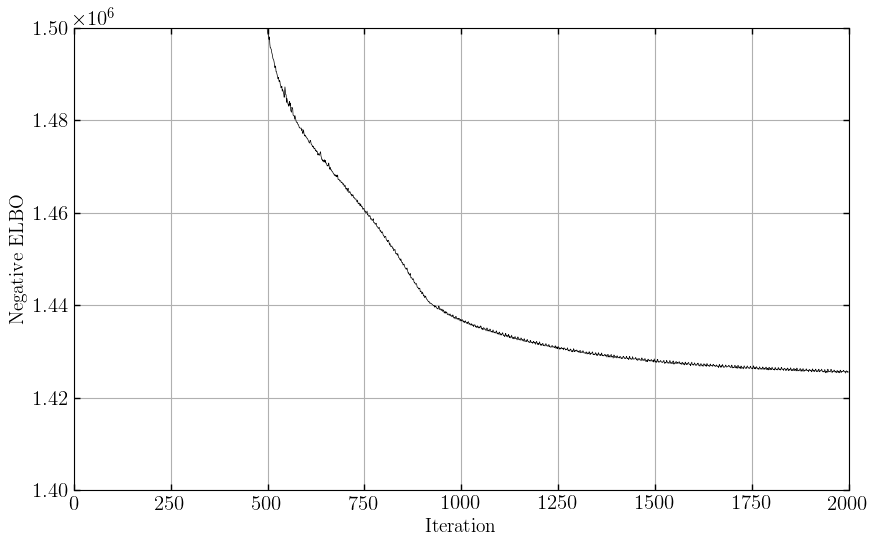

In [21]:
plt.figure(figsize=(10,6))
plt.plot(bkg_svi_results.losses, lw=0.5)
# plt.yscale("log")
plt.xlim(0,2e3) ; plt.ylim(1.4e6, 1.5e6)
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

MAP_p_bkg_expanded = get_svi_params(model=bkg_model, data=bkg_data, svi_results=bkg_svi_results, 
                                   guide=bkg_guide, num_samples=1, key=jax.random.PRNGKey(12345))

Note: We need to keep the number of samples created as 1 because when taking the median, I might get values of the mixing probabilities that do not sum to 1, making them unable 
to be used as initial parameters for the component mixture models. One alternative would be to take the median of one of the mixing probabilities and to fix the other one such that they sum to 1.
Or not!

Can I get the mixing distributions to be splines as well??? Do I need to, given how good the background looks already?

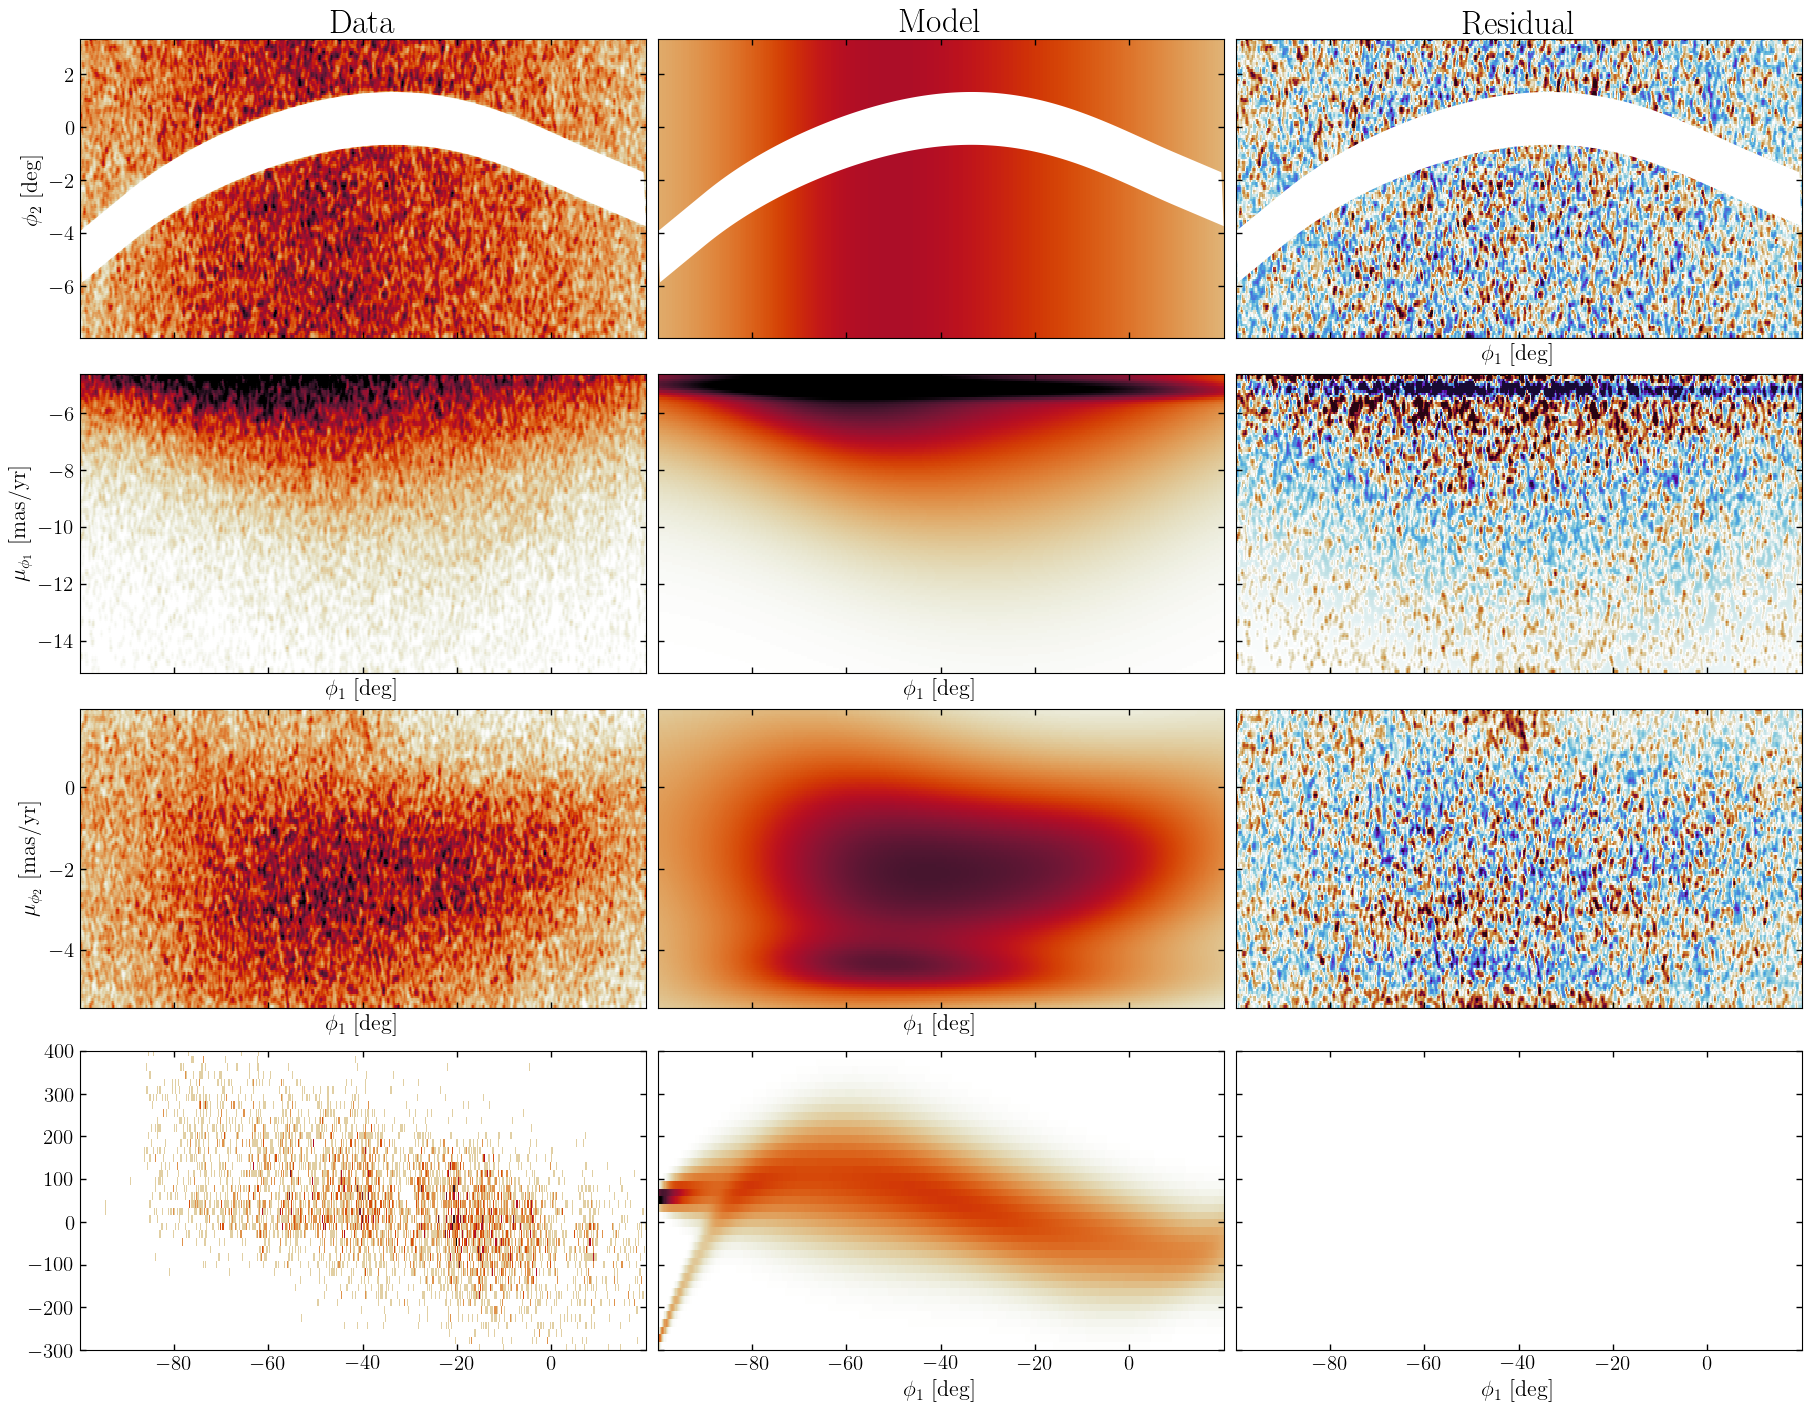

In [24]:
fig, axes = plt.subplots(
    len(bkg_model.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(bkg_model.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=axes[1, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'pm1')]
)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[axes[0, 0], axes[2,0]],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
axes[3,0].hist2d(bkg_data_['phi1'][bkg_data_['rv'] != 0], bkg_data_['rv'][bkg_data_['rv'] != 0], bins=[512, 128], range=[[phi1_lim[0],phi1_lim[1]], [rv_lim[0],rv_lim[1]]], cmap=cmap)

# bkg_model.plot_model_projections(ndata=len(bkg_data_), grids=plot_grids, pars=MAP_p_bkg_expanded, axes=axes[:, 1], label=False,
#                                      pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0))
bkg_model.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'pm1')],
                                 pars=MAP_p_bkg_expanded, axes=axes[1, 1], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                                 pars=MAP_p_bkg_expanded, axes=[axes[0, 1], axes[2,1]], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(ndata=len(run_data_['rv'][run_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'rv')],
                                 pars=MAP_p_bkg_expanded, axes=axes[3, 1], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

bkg_model.plot_residual_projections(
    grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], 
    pars=MAP_p_bkg_expanded,
    data=run_data, axes=axes[0, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap=cmr.fusion, rasterized=True)
)
bkg_model.plot_residual_projections(
    grids=plot_grids, grid_coord_names=[('phi1', 'pm1'), ('phi1', 'pm2')],
    pars=MAP_p_bkg_expanded, data=bkg_data, axes=axes[1:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap=cmr.fusion, rasterized=True)
)

blank = cmr.take_cmap_colors(cmap, N=2, return_fmt='hex')[0]
for ax in axes[0,:]:
    patch_sky = mpl.patches.Polygon(
            iso_obj.pawprint.skyprint["stream"].vertices[::50],
            facecolor=blank,
            alpha=1
        )
    ax.add_patch(patch_sky)

axes[3,0].set_ylim(-300, 400) ; axes[3,1].set_ylim(-300, 400)

axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

# Stream

In [25]:
importlib.reload(init_stream)

<module 'initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/scripts/initialize_stream.py'>

Can I / should I be a bit more rigid with the priors on the edges of GD-1? Notice that without that, the left edge of the stream deviates significantly away from what other studeis have shown in the full model a bit below (this is not a problem with the stream model by itself since it is trained on only the data around the galstreams track). It is probably worth it to run once where the phi2_mean is limited to a certain range above/below the galstreams track to see if we pick up more stars that way.

In [26]:
stream_knot_spacings=[5,10,10,10,10]

stream_model = init_stream.make_stream_model_component(knot_spacings=stream_knot_spacings, coord_bounds=coord_bounds, data=stream_data)

In [23]:
stream_phi1_knots = stream_model.coord_parameters['phi1']['locs'][0]
stream_phi2_knots = stream_model.coord_parameters['phi2']['knots']
stream_pm1_knots = stream_model.coord_parameters['pm1']['knots']
stream_pm2_knots = stream_model.coord_parameters['pm2']['knots']
stream_rv_knots = stream_model.coord_parameters['rv']['knots']

_interp_dict = init_stream.interpolate_stream_tracks(stream_data, phi1_lim)
eval_interp_phi2 = jnp.array(_interp_dict['phi2'](stream_phi2_knots))
eval_interp_pm1 = jnp.array(_interp_dict['pm1'](stream_pm1_knots))
eval_interp_pm2 = jnp.array(_interp_dict['pm2'](stream_pm2_knots))
eval_interp_rv = jnp.array(_interp_dict['rv'](stream_rv_knots))

stream_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(len(stream_phi1_knots))
        / len(stream_phi1_knots),
        "scales": jnp.full(stream_phi1_knots.shape[0], stream_knot_spacings[0]),
    },
    "phi2": {
        "loc_vals": eval_interp_phi2,
        "scale_vals": jnp.full(stream_phi2_knots.shape[0], 0.5),
    },
    "pm1": {
        "loc_vals": eval_interp_pm1,
        "scale_vals": jnp.full(stream_pm1_knots.shape[0], 0.35),
    },
    "pm2": {
        "loc_vals": eval_interp_pm2,
        "scale_vals": jnp.full(stream_pm2_knots.shape[0], 0.35),
    },
    "rv": {
        "loc_vals": eval_interp_rv,
        "scale_vals": jnp.full(stream_rv_knots.shape[0], 4),
    },
}

In [156]:
low, high =coord_bounds['pm1']
low

Array(-15.09995579, dtype=float64)

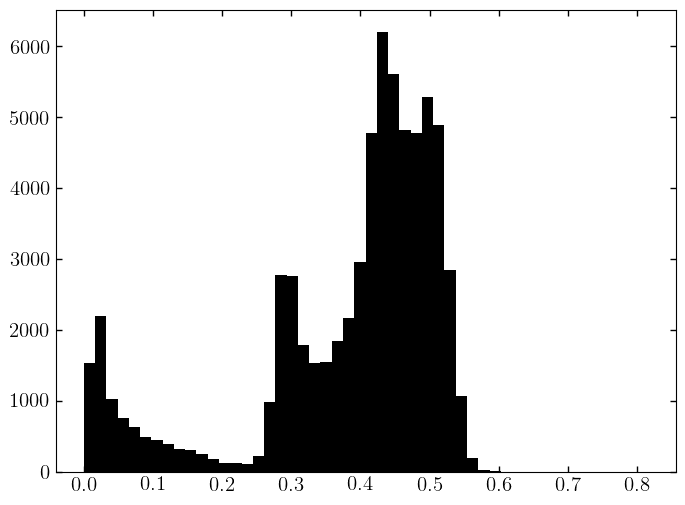

In [232]:
z=bkg_svi_results.params['background:rv:modeldata_auto_scale']

x_real = jnp.exp(z)-1

plt.hist(x_real, bins=50)
plt.show()

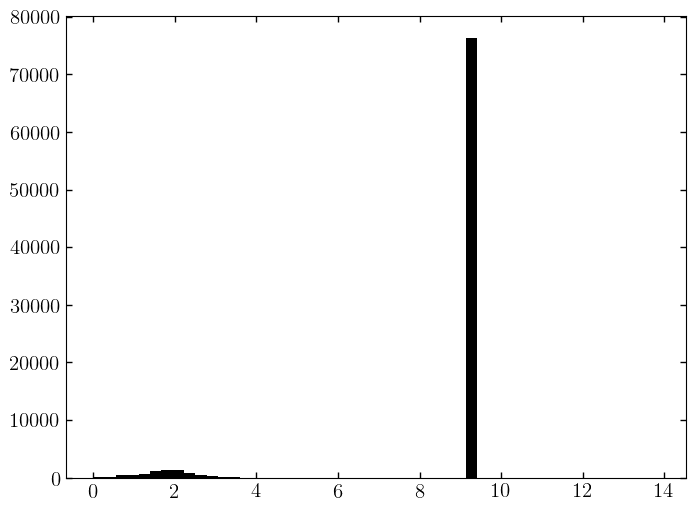

In [237]:
plt.hist(np.log(run_data_['rv_err']+1), bins=50)

plt.show()

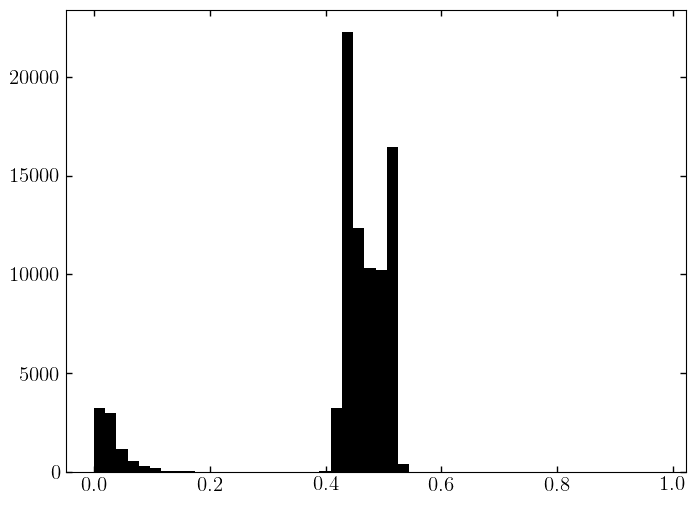

In [235]:
plt.hist(svi_results.params['mixture:modeldata_auto_scale'][:,4], bins=50)
# plt.yscale('log')
plt.show()

In [24]:
# _ = stream_model.plot_model_projections(data=stream_data, pars=stream_init_params, grids=plot_grids)

In [26]:
keys = jax.random.split(jax.random.PRNGKey(42), num=2)
stream_svi_results, stream_guide = run_SVI(stream_model, stream_init_params, stream_data, stream_data_err,
                                           num_steps=10_000, GuideFunction=AutoNormal, keys=keys,
                                           init_lr=1e-2, adaptive_lr=True, num_particles=10)

100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:24<00:00, 26.04it/s, init loss: 652427147.7359, avg. loss [9501-10000]: 26821.9782]


In [27]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
stream_filename = svi_results_dir + 'stream_{}_{}_{}_{}_{}.pkl'.format(*stream_knot_spacings)
with open(stream_filename, 'rb') as input_file_:
    stream_dict = pickle.load(input_file_)
stream_svi_results = stream_dict['svi_results']
stream_guide = stream_dict['guide']

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_97905/1806601770.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 5e4) ; #plt.ylim(23.5e3,25e3)


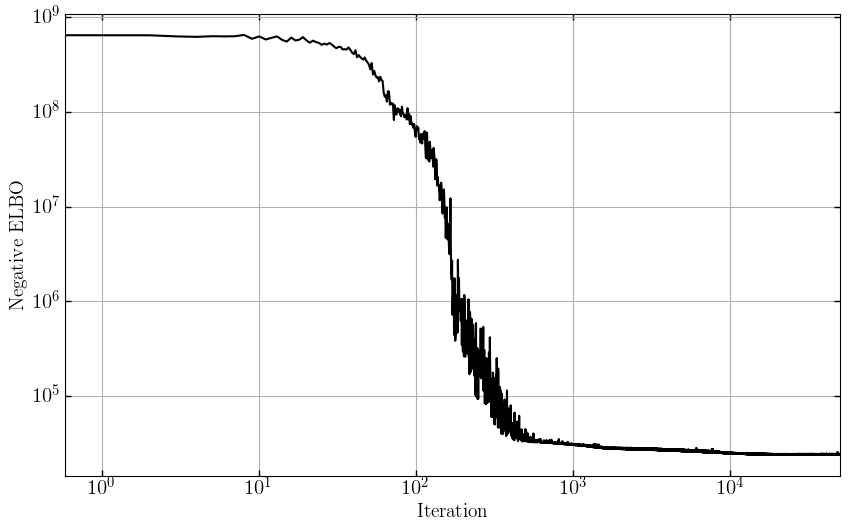

In [32]:
plt.figure(figsize=(10,6))
plt.plot(stream_svi_results.losses)
plt.yscale("log") ; plt.xscale("log")
plt.xlim(0, 5e4) ; #plt.ylim(23.5e3,25e3)
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

MAP_p_stream_expanded = get_svi_params(model=stream_model, data=stream_data, svi_results=stream_svi_results, 
                                       guide=stream_guide, num_samples=1, key=jax.random.PRNGKey(12345))

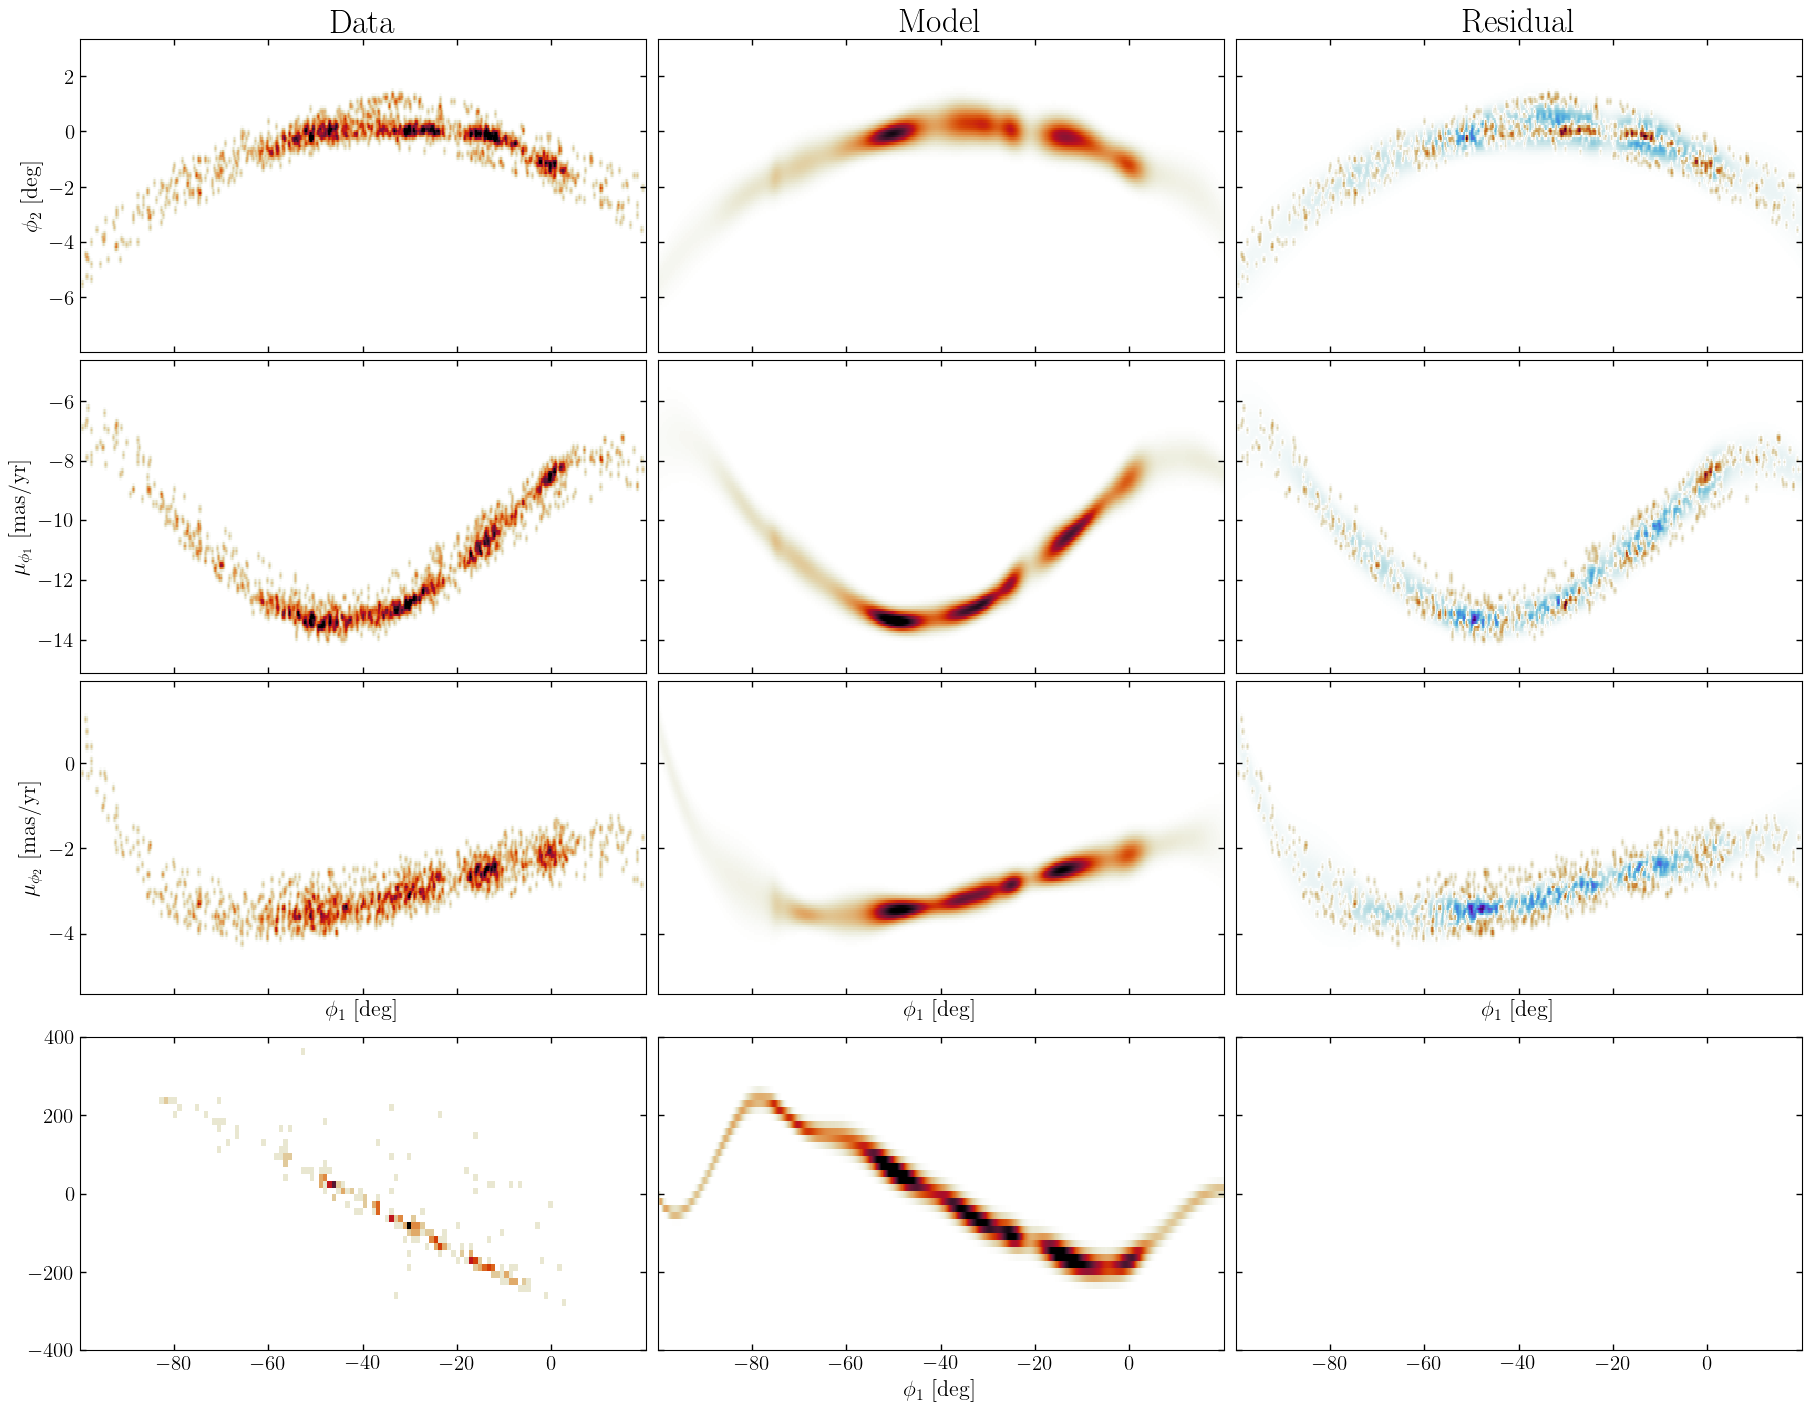

In [33]:
fig, axes = plt.subplots(
    len(stream_model.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_model.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    axes=axes[:3, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap)
    # coord_names=GD1BackgroundModel.coord_names,
)
axes[3,0].hist2d(stream_data_['phi1'][stream_data_['rv'] != 0], stream_data_['rv'][stream_data_['rv'] != 0], bins=[128, 128], range=[[phi1_lim[0],phi1_lim[1]], [rv_lim[0],rv_lim[1]]], cmap=cmap)


stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
                                    pars=MAP_p_stream_expanded, axes=axes[:3, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, grid_coord_names=[('phi1','rv')],
                                    pars=MAP_p_stream_expanded, axes=axes[3, 1], label=False,
                                    pcolormesh_kwargs=dict(rasterized=True, vmax=2, vmin=0, cmap=cmap))

stream_model.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_stream_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    data=stream_data, axes=axes[:3, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap=cmr.fusion, rasterized=True)
)
axes[3,0].set_ylim(-400, 400)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

In [33]:
MAP_p_stream_expanded['rv']

{'loc_vals': Array([ -52.86583888,  203.96253325,  183.99621839,  100.91900068,
         -14.55611956, -105.83421729, -178.6650285 , -161.26623314,
          20.87514692], dtype=float64),
 'modeldata': Array([217.05522388, 207.28197021, 208.61379017, ..., 130.02017396,
        122.14952051, 137.84375967], dtype=float64),
 'scale_vals': Array([ 8.17841332, 15.43370767, 14.51183287, 19.97901514, 19.95942738,
        19.95024664, 19.90908998, 19.82990856,  7.19463809], dtype=float64)}

# Mixture of Stream + Background (no off-track)

In [34]:
importlib.reload(init_stream)

<module 'initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/scripts/initialize_stream.py'>

In [35]:
bkg_model = init_stream.make_bkg_model_component(knot_spacings=bkg_knot_spacings, n_mixture=n_mixture, 
                                                 coord_bounds=coord_bounds, data=run_data)

stream_model = init_stream.make_stream_model_component(knot_spacings=stream_knot_spacings, 
                                                       coord_bounds=coord_bounds, data=run_data)

In [36]:
stream_bkg_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])), components=[bkg_model, stream_model]
)

In [113]:
f_stream = jnp.around(len(stream_data_)/len(run_data_), 3)
print(f_stream)

0.018000000000000002


In [239]:
# init_params = {"background": MAP_p_bkg_expanded, "stream": MAP_p_stream_expanded}
# packed_params = stream_bkg_mm.pack_params(init_params)
filtered_bkg_results = {key: value for key, value in bkg_svi_results.params.items() if not "modeldata" in key}
filtered_stream_results = {key: value for key, value in stream_svi_results.params.items() if not "modeldata" in key}
packed_params = filtered_bkg_results | filtered_stream_results
packed_params["mixture-probs"] = jnp.array([1-f_stream, f_stream])
# packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

# _ = stream_bkg_mm.plot_model_projections(ndata=len(run_data_), pars=packed_params, grids=plot_grids)

In [241]:
def transformtruncnorm2unconstrainedspace(x, low, high):
    return jnp.log((x - low) / (high - x))

In [242]:
stacked_data = run_data_['phi1','phi2','pm1','pm2','rv']
trans_stacked_data = np.zeros((len(run_data_), 5))
for i, col in enumerate(stacked_data.colnames):
    trans_data = transformtruncnorm2unconstrainedspace(stacked_data[col], coord_bounds[col][0]-1e-4, coord_bounds[col][1]+1e-4)
    trans_stacked_data[:,i] = trans_data

packed_params["mixture:modeldata_auto_loc"] = trans_stacked_data

In [140]:
specifications = [40,40,40,40,5,20,20,20,20]

svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/old_init/'
# filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_stream{}_{}_{}_{}_off{}_{}.pkl'.format(*specifications)
filename = svi_results_dir + 'mm_bkg{}_{}_{}_{}_stream{}_{}_{}_{}_{}.pkl'.format(*specifications)

with open(filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
svi_results = full_dict['svi_results']
guide = full_dict['guide']

In [247]:
packed_params["mixture:modeldata_auto_loc"] = svi_results.params['mixture:modeldata_auto_loc']
packed_params["mixture:modeldata_auto_scale"] = svi_results.params['mixture:modeldata_auto_scale']

In [248]:
packed_params['mixture-probs']

Array([0.982, 0.018], dtype=float64)

In [249]:
optimizer = numpyro.optim.ClippedAdam(5e-3)
# Define the guide
guide = AutoNormal(
    stream_bkg_mm, init_loc_fn=numpyro.infer.init_to_value(values=packed_params)
)

In [250]:
keys = jax.random.split(jax.random.PRNGKey(423), num=2)

svi = SVI(stream_bkg_mm, guide, optimizer, Trace_ELBO(num_particles=1))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    init_state = svi.init(keys[0], init_params=packed_params, data=run_data, err=run_data_err)
    # svi.evaluate(rng_key=keys[1], init_state=init_state, data=data, err=err)

In [251]:
svi.evaluate(svi_state=init_state, data=run_data, err=run_data_err)

Array(2410241.56791911, dtype=float64)

In [256]:
no_off_svi_results, no_off_guide = run_SVI(stream_bkg_mm, packed_params, run_data, run_data_err,
                                                   num_steps=200, GuideFunction=AutoNormal, keys=keys,
                                                   init_lr=1e-5, adaptive_lr=False, num_particles=1)

 42%|███████████████████████████████████████▉                                                       | 84/200 [01:50<02:32,  1.31s/it, init loss: 2410241.5679, avg. loss [71-80]: 2089975.2971]


KeyboardInterrupt: 

In [ ]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
all_knot_spacings = jnp.concatenate([jnp.array(bkg_knot_spacings), jnp.array(stream_knot_spacings)])
stream_bkg_mm_filename = svi_results_dir + 'mm_bkg{}_{}_{}_stream{}_{}_{}_{}.pkl'.format(*all_knot_spacings)
with open(stream_bkg_mm_filename, 'rb') as input_file_:
    stream_bkg_mm_dict = pickle.load(input_file_)
no_off_svi_results = stream_bkg_mm_dict['svi_results']
no_off_guide = stream_bkg_mm_dict['guide']

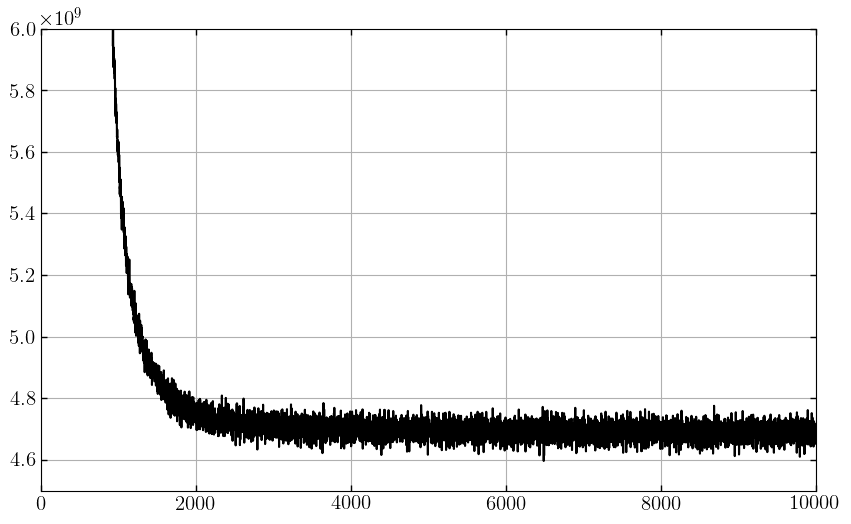

In [137]:
plt.figure(figsize=(10,6))
plt.plot(no_off_svi_results.losses)
# plt.yscale("log")
plt.xlim(0, 10e3)
plt.ylim(4.5e9,6e9)
plt.grid()

pred_dist = Predictive(no_off_guide, params=no_off_svi_results.params, num_samples=1)
MAP_p_no_off_ = pred_dist(jax.random.PRNGKey(42))
MAP_p_no_off = {k: jnp.median(v, axis=0) for k, v in MAP_p_no_off_.items()}
no_off_params = stream_bkg_mm.expand_numpyro_params(MAP_p_no_off)

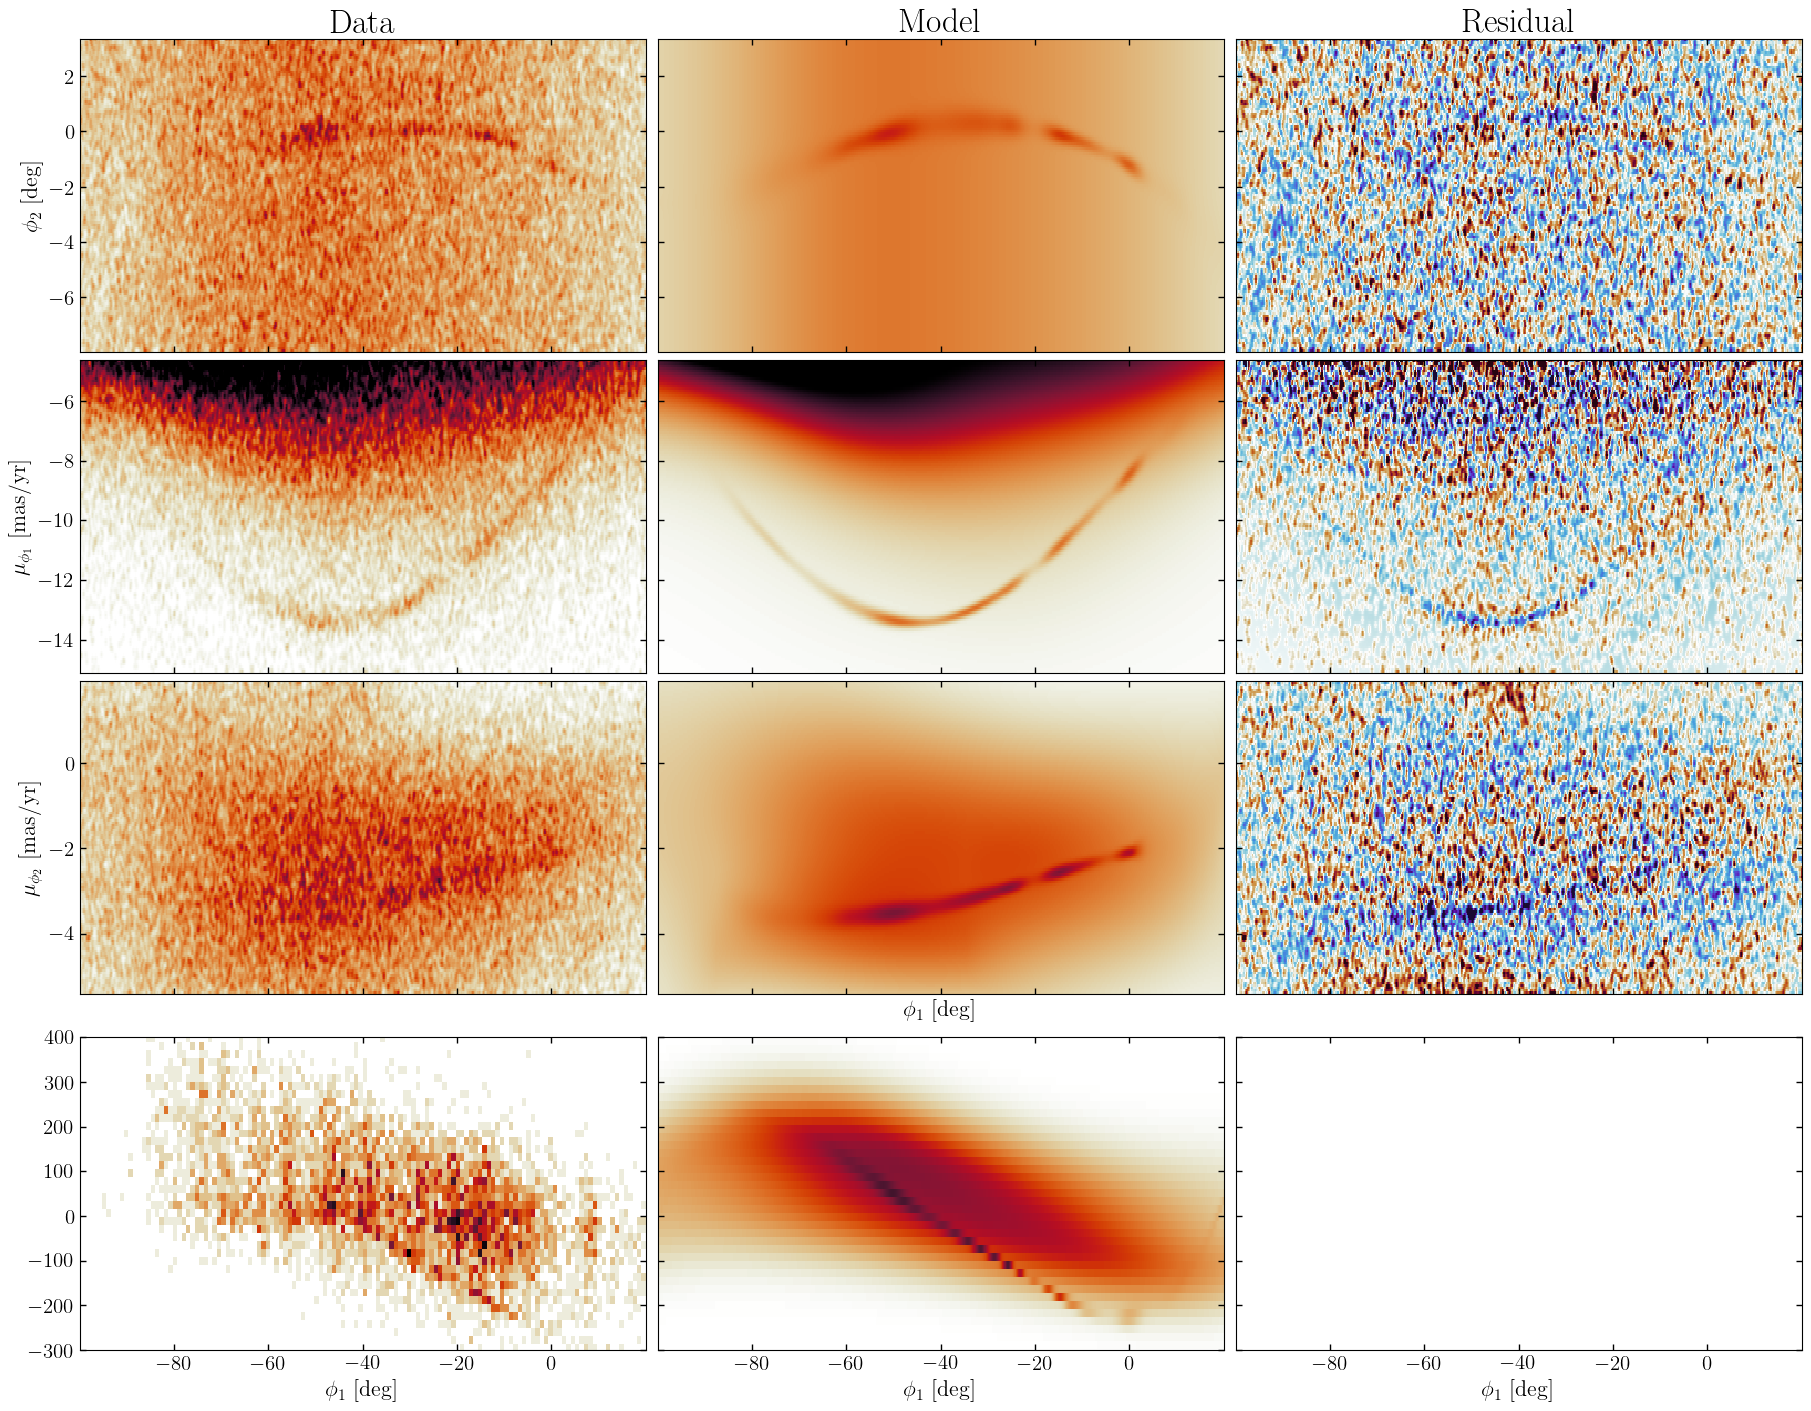

In [133]:
fig, axes = plt.subplots(
    len(stream_bkg_mm.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_bkg_mm.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
    # coord_names=GD1BackgroundModel.coord_names,
)
axes[3,0].hist2d(run_data_['phi1'][run_data_['rv'] != 0], run_data_['rv'][run_data_['rv'] != 0], bins=[128, 128], range=[[phi1_lim[0],phi1_lim[1]], [rv_lim[0],rv_lim[1]]], cmap=cmap)

stream_bkg_mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, pars=MAP_p_no_off_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
                                     axes=axes[:3, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
stream_bkg_mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1','rv')],
                                    pars=MAP_p_no_off_expanded, axes=axes[3, 1], label=False,
                                    pcolormesh_kwargs=dict(rasterized=True, vmax=20, vmin=0, cmap=cmap))

stream_bkg_mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_no_off_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    data=run_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap=cmr.fusion, rasterized=True)
)

axes[3,0].set_ylim(-300, 400)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

In [ ]:
# with open('../data/mix_opt_params.pkl', 'wb') as output:
#     pickle.dump(mix_opt_pars, output)

# Off-track

We also include an "off-track" model that uses the 2D grid of Normals for the sky distribution but uses the same $\mu_{\phi_i}$ tracks as the stream model.

In [134]:
importlib.reload(init_stream)

<module 'initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/scripts/initialize_stream.py'>

In [135]:
offtrack_dx=[4,1]

offtrack_model, offtrack_phi12_locs = init_stream.make_offtrack_model_component(offtrack_dx, stream_model, coord_bounds)

In [138]:
## Untie the offtrack model and create tight priors around stream+background results instead
##  This can't be splines since I wouldn't expect this to vary continuously
offtrack_model.coord_parameters['pm1']['loc_vals'] = dist.TruncatedNormal(
    loc=no_off_params['stream']['pm1']['loc_vals'],
    scale=no_off_params['stream']['pm1']['scale_vals'],
    low=no_off_params['stream']['pm1']['loc_vals']-3*no_off_params['stream']['pm1']['scale_vals'],
    high=no_off_params['stream']['pm1']['loc_vals']+3*no_off_params['stream']['pm1']['scale_vals']
    )
offtrack_model.coord_parameters['pm2']['loc_vals'] = dist.TruncatedNormal(
    loc=no_off_params['stream']['pm2']['loc_vals'],
    scale=no_off_params['stream']['pm2']['scale_vals'],
    low=no_off_params['stream']['pm2']['loc_vals']-3*no_off_params['stream']['pm2']['scale_vals'],
    high=no_off_params['stream']['pm2']['loc_vals']+3*no_off_params['stream']['pm2']['scale_vals'])
offtrack_model.coord_parameters['rv']['loc_vals'] = dist.TruncatedNormal(
    loc=no_off_params['stream']['rv']['loc_vals'],
    scale=no_off_params['stream']['rv']['scale_vals'],
    low=no_off_params['stream']['rv']['loc_vals']-3*no_off_params['stream']['rv']['scale_vals'],
    high=no_off_params['stream']['rv']['loc_vals']+3*no_off_params['stream']['rv']['scale_vals'])

offtrack_model.coord_parameters['pm1']['scale_vals'] = dist.TruncatedNormal(
    loc=no_off_params['stream']['pm1']['scale_vals'],
    scale=no_off_params['stream']['pm1']['scale_vals'],
    low=0, high=3*no_off_params['stream']['pm1']['scale_vals'])
offtrack_model.coord_parameters['pm2']['scale_vals'] = dist.TruncatedNormal(
    loc=no_off_params['stream']['pm2']['scale_vals'],
    scale=no_off_params['stream']['pm2']['scale_vals'],
    low=0, high=3*no_off_params['stream']['pm2']['scale_vals'])
offtrack_model.coord_parameters['rv']['scale_vals'] = dist.TruncatedNormal(
    loc=no_off_params['stream']['rv']['scale_vals'],
    scale=no_off_params['stream']['rv']['scale_vals'],
    low=0, high=3*no_off_params['stream']['rv']['scale_vals'])
offtrack_model.coord_parameters['pm1']['x'] = run_data['phi1']
offtrack_model.coord_parameters['pm2']['x'] = run_data['phi1']
offtrack_model.coord_parameters['rv']['x'] = run_data['phi1']


In [139]:
# _init_prob = (
#     jnp.exp(-0.5 * (offtrack_phi12_locs[:, 0] - -35) ** 2 / 4**2)
#     * jnp.exp(-0.5 * (offtrack_phi12_locs[:, 1] - 1.5) ** 2 / 0.5**2)
#     + 1e-5
# )
_init_prob = jnp.ones(len(offtrack_phi12_locs))
_init_prob /= _init_prob.sum()

offtrack_init_params = {
    ("phi1", "phi2"): {
        "mixing_distribution": _init_prob,
        "scales": jnp.array([offtrack_dx] * len(offtrack_phi12_locs)).T,
    },
    "pm1": no_off_params['stream']['pm1'],
    "pm2": no_off_params['stream']['pm2'],
    "rv": no_off_params['stream']['rv'],
}

(-300.0, 400.0)

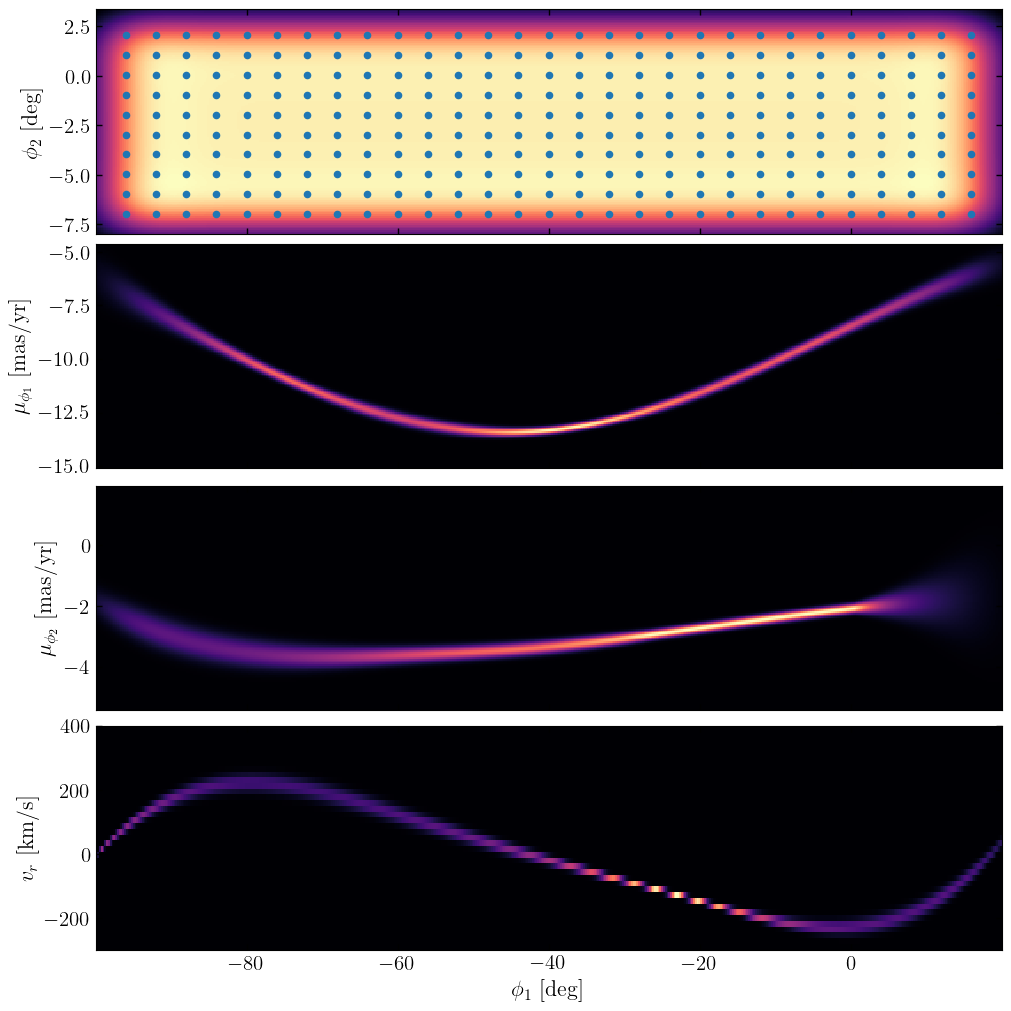

In [142]:
fig, axes, _ = offtrack_model.plot_model_projections(pars=offtrack_init_params, grids=plot_grids)
axes[0].scatter(
    offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=20
)
axes[3].set_ylim(-300, 400)

# fig, axes, _ = plot_data_projections(data=run_data, grids=plot_grids)
# axes[0].scatter(
#     offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=20
# )

In [143]:
mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0, 1.0])),
    components=[bkg_model, stream_model, offtrack_model],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

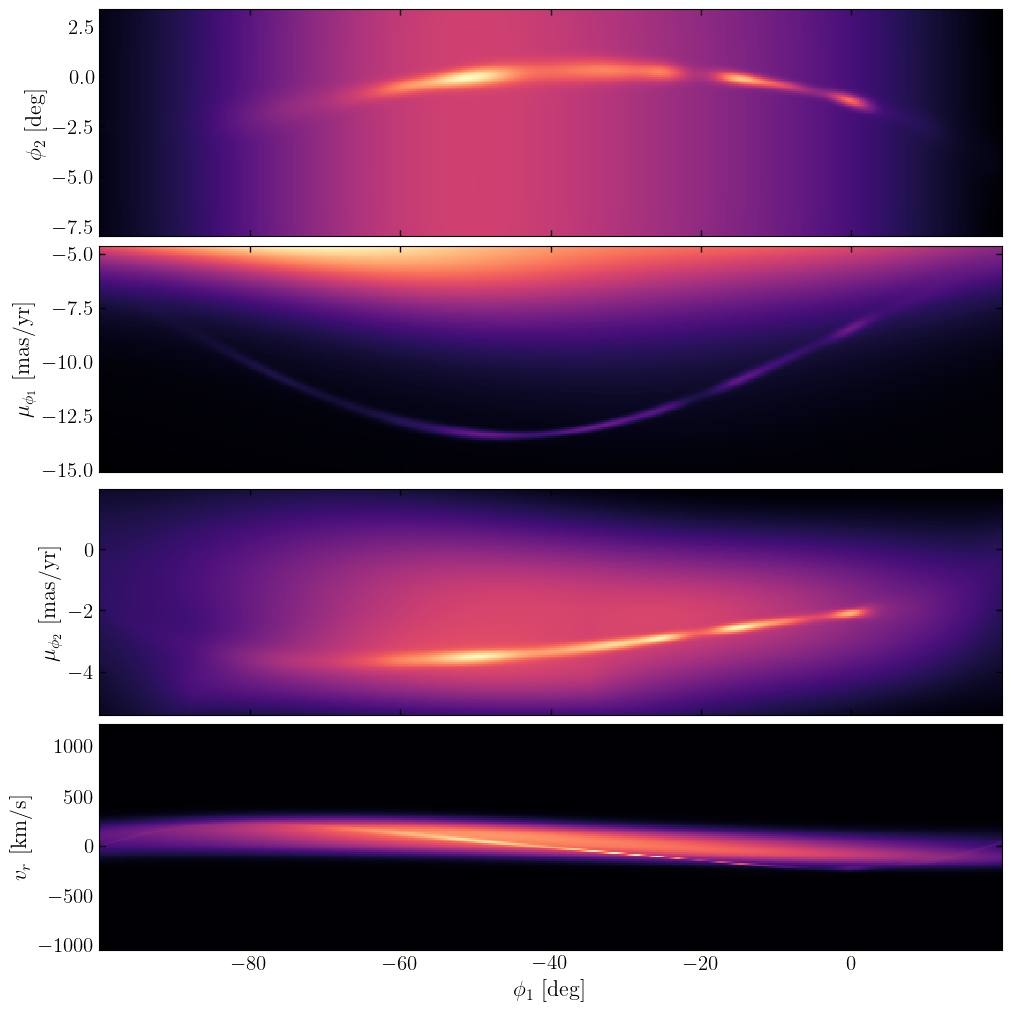

In [144]:
mm_init_params = {
    "background": no_off_params["background"],
    "stream": no_off_params['stream'], # take from stream model rather than stream+background so that it doesn't have the spur
    "offtrack": offtrack_init_params,
}
mm_packed_params = mm.pack_params(mm_init_params)
mm_packed_params["mixture-probs"] = jnp.array([0.978, 0.017, 0.005])
mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

_ = mm.plot_model_projections(mm_packed_params, grids=plot_grids)

In [145]:
full_svi_results, full_guide = run_SVI(mm, mm_packed_params, run_data, run_data_err,
                                           num_steps=20_000, GuideFunction=AutoNormal, keys=keys,
                                           learning_rate=1e-2, num_particles=2)

100%|██████████| 20000/20000 [5:00:42<00:00,  1.11it/s, init loss: 7481799079993610.0000, avg. loss [19001-20000]: 4573136103.9133]  


In [ ]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
specifications = jnp.concatenate([jnp.array(bkg_knot_spacings), jnp.array(stream_knot_spacings), jnp.array(offtrack_dx)])
mm_filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_stream{}_{}_{}_{}_off{}_{}.pkl'.format(*specifications)
with open(mm_filename, 'rb') as input_file_:
    mm_dict = pickle.load(input_file_)
full_svi_results = mm_dict['svi_results']
full_guide = mm_dict['guide']

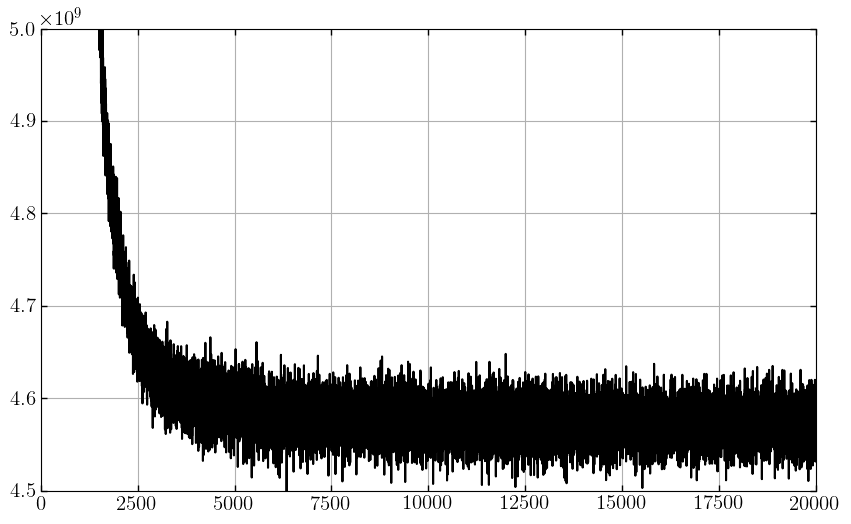

In [148]:
plt.figure(figsize=(10,6))
plt.plot(full_svi_results.losses)
plt.xlim(0, 20e3)
plt.ylim(4.5e9,5e9)
plt.grid()
plt.show()

In [149]:
pred_dist = Predictive(full_guide, params=full_svi_results.params, num_samples=10_000)
MAP_p_ = pred_dist(jax.random.PRNGKey(42))
MAP_p = {k: jnp.median(v, axis=0) for k, v in MAP_p_.items()}
MAP_p_expanded = mm.expand_numpyro_params(MAP_p)

: 

In [ ]:
MAP_p_expanded

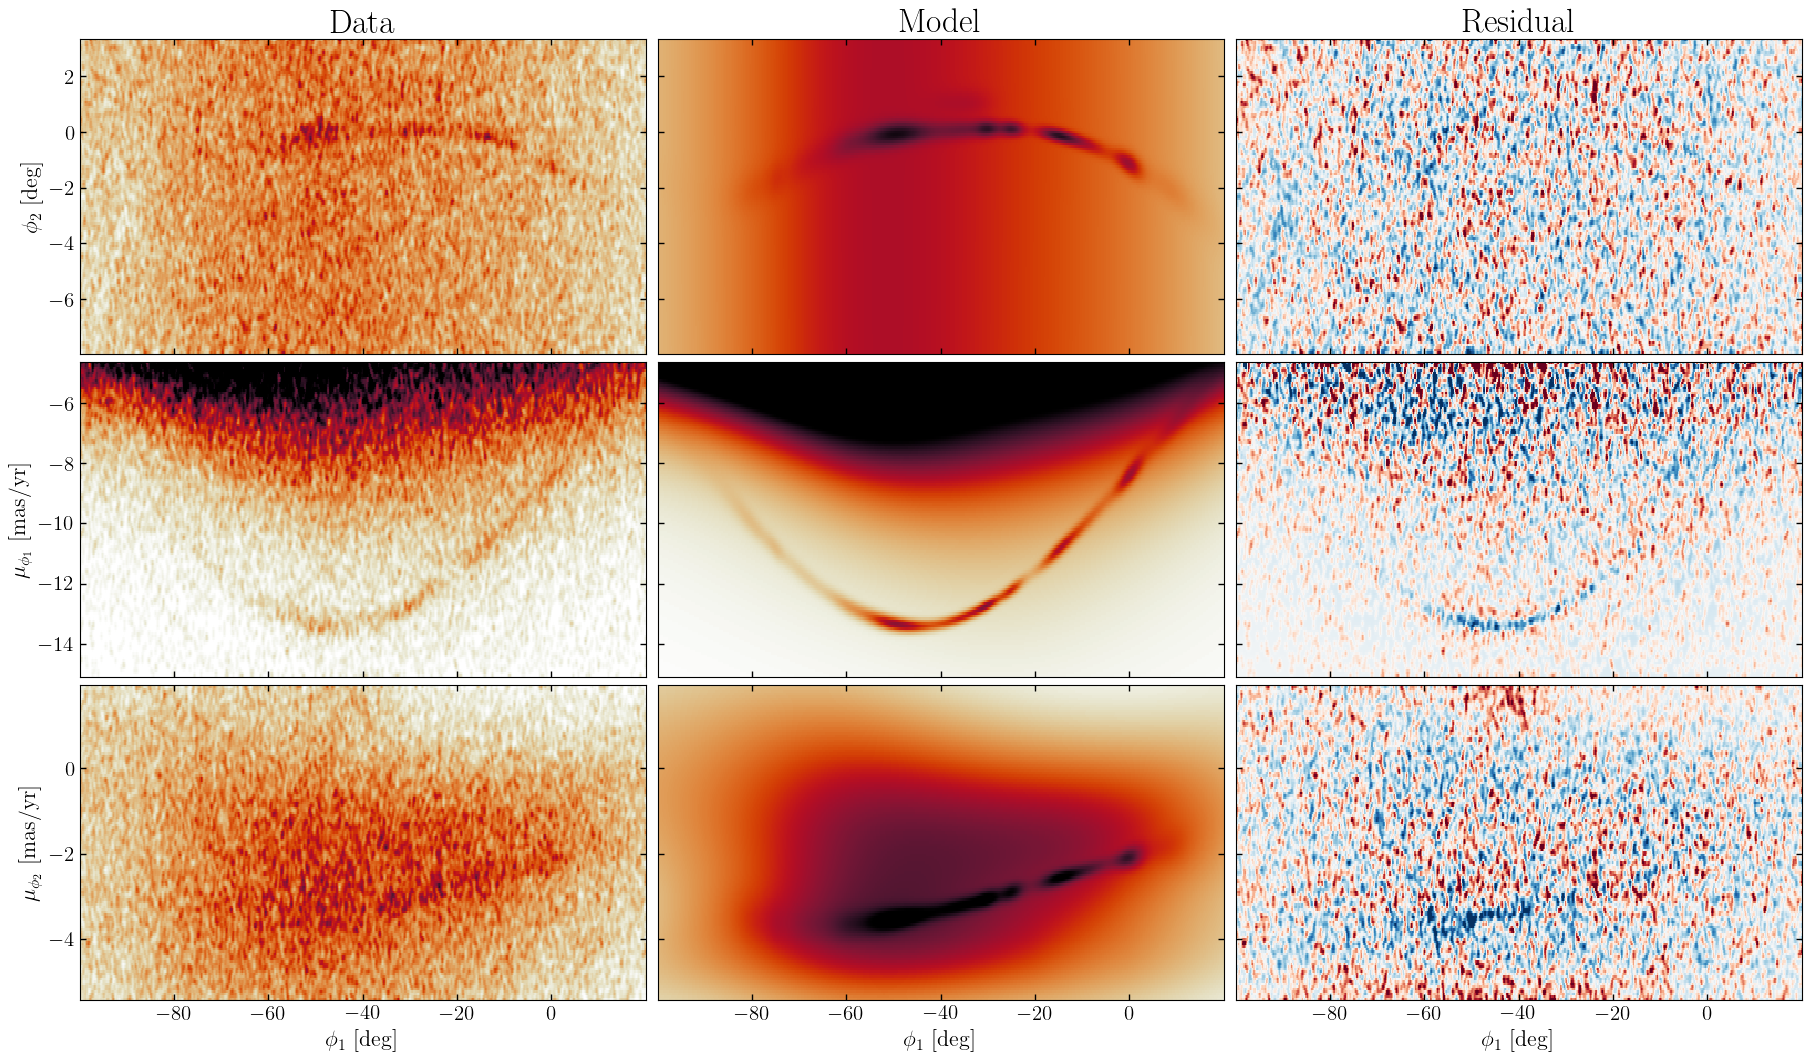

In [ ]:
fig, axes = plt.subplots(
    len(mm.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(mm.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

#axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=axes[:, 0],
    coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')]
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
    # coord_names=GD1BackgroundModel.coord_names,
)
axes[3,0].hist2d(run_data_['phi1'][run_data_['rv'] != 0], run_data_['rv'][run_data_['rv'] != 0], bins=[128, 128], range=[[phi1_lim[0],phi1_lim[1]], [rv_lim[0],rv_lim[1]]], cmap=cmap)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, pars=MAP_p_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
                          axes=axes[:3, 1], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1','rv')],
                                    pars=MAP_p_expanded, axes=axes[3, 1], label=False,
                                    pcolormesh_kwargs=dict(rasterized=True, vmax=20, vmin=0, cmap=cmap))
mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    data=run_data, axes=axes[:3, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)

# plt.savefig('../figures/
plt.show()

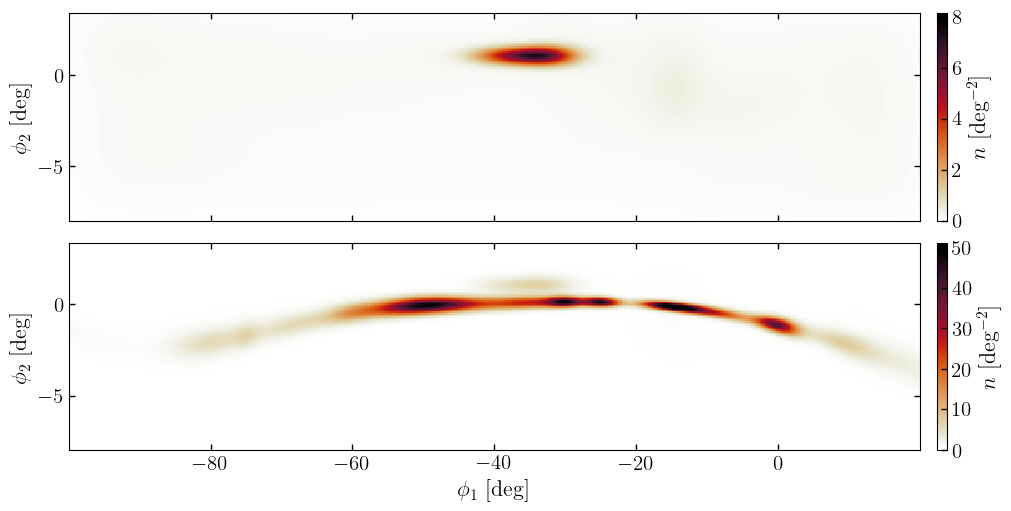

In [ ]:
import matplotlib.ticker as mticker
str_off_mm = ComponentMixtureModel(
dist.Dirichlet(jnp.array([1.0, 1.0])),
components=[stream_model, offtrack_model],
# tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

str_off_mm_params = {
    "stream": MAP_p_expanded["stream"],
    "offtrack": MAP_p_expanded["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = MAP_p_expanded["mixture-probs"][1:] / jnp.sum(MAP_p_expanded["mixture-probs"][1:])
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

bin_area = jnp.diff(plot_grids['phi1'])[0] * jnp.diff(plot_grids['phi2'])[0]

fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,5), sharex=True, constrained_layout=True)
_, _, pcms1 = mm['offtrack'].plot_model_projections(ndata=len(run_data_) * MAP_p_expanded["mixture-probs"][2], 
                                                    grids=plot_grids, pars=MAP_p_expanded['offtrack'], grid_coord_names=[('phi1', 'phi2')], axes=ax1,
                                                    pcolormesh_kwargs=dict(rasterized=True, vmax=0.17, vmin=0, cmap=cmap))
cbar1 = fig.colorbar(pcms1[0], ax=ax1, ticks=jnp.array([0, 2, 4, 6, 8, 10])*bin_area, pad=0.02,
           format=mticker.FixedFormatter(['0', '2', '4', '6', '8', '10']))

_, _, pcms2 = str_off_mm.plot_model_projections(ndata=len(run_data_) * jnp.sum(MAP_p_expanded["mixture-probs"][1:]),
                                                pars=str_off_mm_packed_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
                                                pcolormesh_kwargs=dict(rasterized=True, vmax=1.07, vmin=0, cmap=cmap))
cbar2 = fig.colorbar(pcms2[0], ax=ax2, ticks=jnp.array([0, 10, 20, 30, 40, 50])*bin_area, pad=0.02,
           format=mticker.FixedFormatter(['0', '10', '20', '30', '40', '50']))




ax1.set_xlabel("")
cbar1.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)

## Make Linear Density Plot

In [ ]:
model_params = MAP_p_expanded

In [ ]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = MAP_p_expanded['stream']
offtrack_params = MAP_p_expanded['offtrack']

grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [ ]:
stream_phi2_knots

Array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.], dtype=float64)

In [ ]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
stream_lin_dens = jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) / (phi1s[1]-phi1s[0])
off_lin_dens = jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) / (phi1s[1]-phi1s[0])


phi2_track = IUS(stream_phi2_knots, stream_params['phi2']['loc_vals'])
phi2_width = IUS(stream_phi2_knots, stream_params['phi2']['scale_vals'])
pm1_track = IUS(stream_pm1_knots, stream_params['pm1']['loc_vals'])
pm1_width = IUS(stream_pm1_knots, stream_params['pm1']['scale_vals'])
pm2_track = IUS(stream_pm2_knots, stream_params['pm2']['loc_vals'])
pm2_width = IUS(stream_pm2_knots, stream_params['pm2']['scale_vals'])


phi2_track_no_off = IUS(stream_phi2_knots, MAP_p_no_off_expanded['stream']['phi2']['loc_vals'])
phi2_width_no_off = IUS(stream_phi2_knots, MAP_p_no_off_expanded['stream']['phi2']['scale_vals'])
pm1_track_no_off = IUS(stream_pm1_knots, MAP_p_no_off_expanded['stream']['pm1']['loc_vals'])
pm1_width_no_off = IUS(stream_pm1_knots, MAP_p_no_off_expanded['stream']['pm1']['scale_vals'])
pm2_track_no_off = IUS(stream_pm2_knots, MAP_p_no_off_expanded['stream']['pm2']['loc_vals'])
pm2_width_no_off = IUS(stream_pm2_knots, MAP_p_no_off_expanded['stream']['pm2']['scale_vals'])

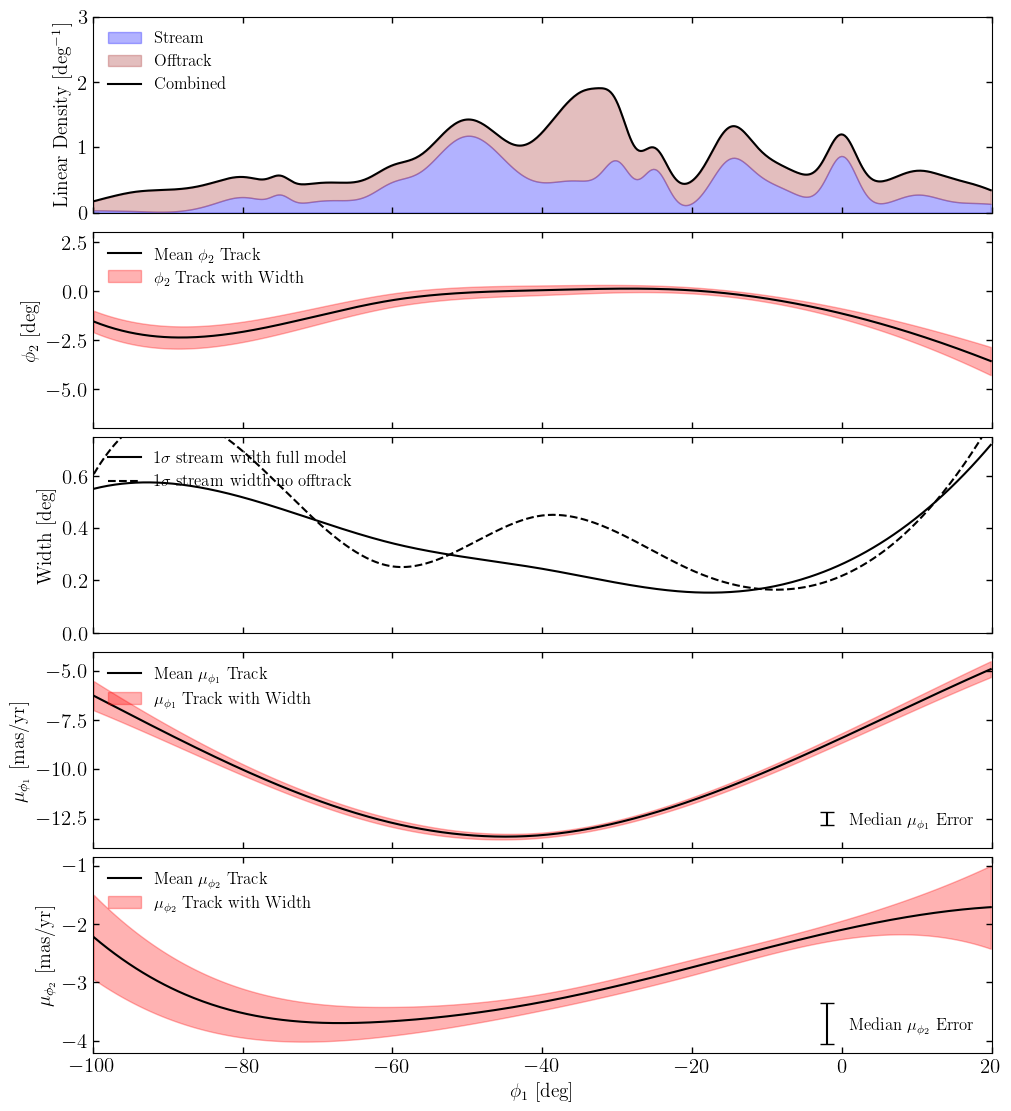

In [ ]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, stream_lin_dens-stream_lin_dens, stream_lin_dens, color='b', alpha=0.3, label=r'Stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='brown', alpha=0.3, label=r'Offtrack')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'Combined')
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,3)
ax1.legend(fontsize=12, loc='upper left')

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'Mean $\phi_2$ Track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\phi_2$ Track with Width')
# ax2.fill_between(phi1s, phi2_track_no_off(phi1s) - phi2_width_no_off(phi1s), 
#                  phi2_track_no_off(phi1s) + phi2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\phi_2$ Track with Width')
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

ax3.plot(phi1s, phi2_width(phi1s), c='k', label=r'$1\sigma$ stream width full model')
ax3.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'$1\sigma$ stream width no offtrack')
ax3.set_ylim(0, 0.75)
ax3.set_ylabel(r'Width [deg]', fontsize=14)
ax3.legend(fontsize=12, loc='upper left')

ax4.plot(phi1s, pm1_track(phi1s), c='k', label=r'Mean $\mu_{\phi_1}$ Track')
ax4.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -12.8, r'Median $\mu_{\phi_1}$ Error', fontsize=12)
ax4.fill_between(phi1s, pm1_track(phi1s) - pm1_width(phi1s), pm1_track(phi1s) + pm1_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
# ax4.fill_between(phi1s, pm1_track_no_off(phi1s) - pm1_width_no_off(phi1s), 
#                  pm1_track_no_off(phi1s) + pm1_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
ax4.set_ylabel(r'$\mu_{\phi_1}$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left')

ax5.plot(phi1s, pm2_track(phi1s), c='k', label=r'Mean $\mu_{\phi_2}$ Track')
ax5.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax5.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, pm2_track(phi1s) - pm2_width(phi1s), pm2_track(phi1s) + pm2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
# ax5.fill_between(phi1s, pm2_track_no_off(phi1s) - pm2_width_no_off(phi1s), 
#                  pm2_track_no_off(phi1s) + pm2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
ax5.set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]', fontsize=14)
ax5.legend(fontsize=12, loc='upper left')

ax5.set_xlim(-100, 20)
ax5.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

# plt.savefig('../paper_figures/stream_properties.pdf')
plt.show()

In [ ]:
all_data_ = iso_obj.cat[pm_mask]
all_data = {k: jnp.array(all_data_[k], dtype="f8") for k in all_data_.colnames}
all_data_err = {'phi1': 1e-8, 'phi2': 1e-8,
                'pm1': jnp.array(all_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(all_data_['pm2_error'], dtype="f8")}

In [ ]:
all_data['phi2'].max()

Array(3.34810289, dtype=float64)

In [ ]:
## membership probability calculation

lp_dict = {} # create dictionary of log probabilities for each component

for n_comp, component in enumerate(mm.components):
    print(component.name) #background, stream, or offtrack

    ## Get distributions for every coordinate in the component
    dists = component.make_dists(model_params[component.name])

    ## Create empty array of log probabilities for each data point and coordinate
    component_lp_stack = jnp.empty((len(dists), len(all_data_)))

    for i, (coord_name, dist_) in enumerate(dists.items()):
        if isinstance(coord_name, tuple): # (phi1, phi2) offtrack
            _data = jnp.stack([all_data[k] for k in coord_name], axis=-1)
            _errors = jnp.stack([all_data_err[k] for k in coord_name], axis=-1)   # Include errors
        else:
            _data = jnp.asarray(all_data[coord_name])
            _errors = jnp.asarray(all_data_err[coord_name])  # Include errors
        
        if isinstance(dist_, (IndependentGMM, dist.Uniform)):
            # IndependentGMM is only used for position space at the moment so ignoring errors is fine
            variable_lp  = dist_.log_prob(value=_data)
            
        elif isinstance(dist_, TruncatedNormalSpline): # One truncated spline
            # Get the spline mean and scale at every data point's phi1
            #  the scale should the the rms of the model scale and the error on that point
            spline_mean = dist_._loc_spl(all_data['phi1'])
            adjusted_spline_scale = jnp.sqrt(dist_._scale_spl(all_data['phi1'])**2 + _errors**2)

            # Get lower and upper bounds of truncated normal (in terms of number of stds from mean)
            lower = (dist_.low - spline_mean) / adjusted_spline_scale
            higher = (dist_.high - spline_mean) / adjusted_spline_scale
            
            # Create a truncated normal per data point
            variable_lp = jax.scipy.stats.truncnorm.logpdf(
                                x=_data, 
                                loc=spline_mean, 
                                scale=adjusted_spline_scale,
                                a=lower,
                                b=higher
                            )
        elif isinstance(dist_, TruncatedNormal1DSplineMixture): # mixture of truncated splines
            # Similar to above
            #  Create the mean and scale at each data point's 'phi1' for each of the truncated splines (shape (K, len(data)))
            spline_mean = jnp.stack([dist_._component_distributions[i]._loc_spl(all_data['phi1']) for i in range(dist_._n_components)])
            spline_scale = jnp.stack([dist_._component_distributions[i]._scale_spl(all_data['phi1']) for i in range(dist_._n_components)])
            adjusted_spline_scale = jnp.sqrt(spline_scale**2 + _errors**2)
            lower = (dist_.low - spline_mean) / adjusted_spline_scale
            higher = (dist_.high - spline_mean) / adjusted_spline_scale

            component_lp = jax.scipy.stats.truncnorm.logpdf(
                                x=_data[None, :], 
                                loc=spline_mean, 
                                scale=adjusted_spline_scale,
                                a=lower,
                                b=higher
                            )
            
            # Including the weights (is this right?)
            mixture_weights = model_params[component.name][coord_name]['mixing_distribution']
            weighted_comp_lp = component_lp + jnp.log(mixture_weights)[:, None]

            variable_lp = jax.scipy.special.logsumexp(weighted_comp_lp, axis=0)
            
        else: # shouldn't be used but is here just in case
            variable_lp = dist_.log_prob(value=_data, x=jnp.asarray(all_data['phi1']))

        # add log prob from this coordinate to the array for this component log prob
        component_lp_stack = component_lp_stack.at[i].set(variable_lp)

    # Get total log probability for this component and put into original dictionary
    comp_lp = jnp.sum(component_lp_stack, axis=0) + jnp.log(model_params['mixture-probs'][n_comp])
    lp_dict[component.name] = comp_lp
    
    print(comp_lp, jnp.max(comp_lp)) 

background
[-10.80417723 -10.25494579 -12.25872613 ... -11.6602238  -13.040243
 -12.04951676] -7.352548183474267
stream
[-300.28353284 -250.53716712  -92.96182049 ... -198.4629012   -78.83113168
 -131.39307701] -5.365129839911522
offtrack
[-232.26249555 -182.06076986  -23.56691133 ... -142.56568564  -23.7913789
  -74.78531968] -7.769939094377271


In [ ]:
sum_probs = jnp.exp(lp_dict['background']) + jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])

In [ ]:
memb_prob = (jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])) / sum_probs
print((memb_prob > 0.5).sum())
print((memb_prob > 0.75).sum())
print((memb_prob > 0.9).sum())
print((memb_prob > 0.99).sum())

2721
1988
1467
486


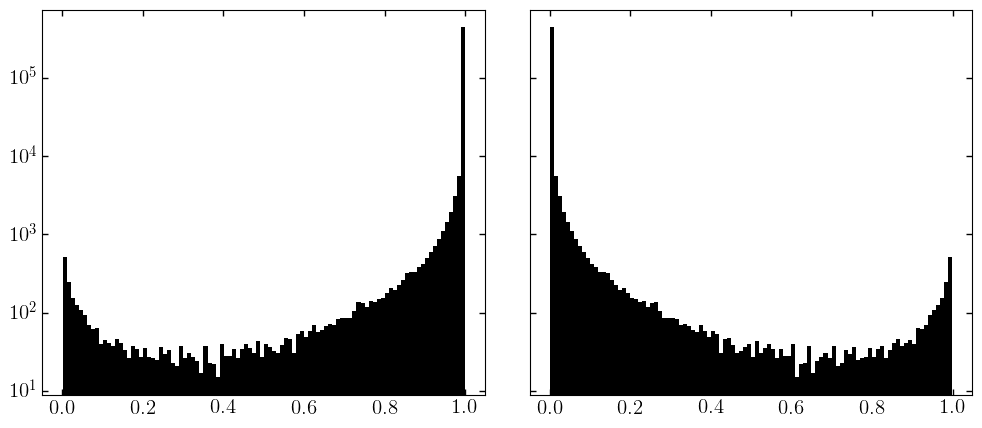

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax1.hist(jnp.exp(lp_dict['background']) / sum_probs, bins=100)
ax1.set_yscale('log')

ax2.hist(memb_prob, bins=100)
ax2.set_yscale('log')

plt.show()

In [ ]:
memb_sel1 = np.array(memb_prob>0.5)
memb_sel2 = np.array(memb_prob>0.75)
memb_sel3 = np.array(memb_prob>0.9)

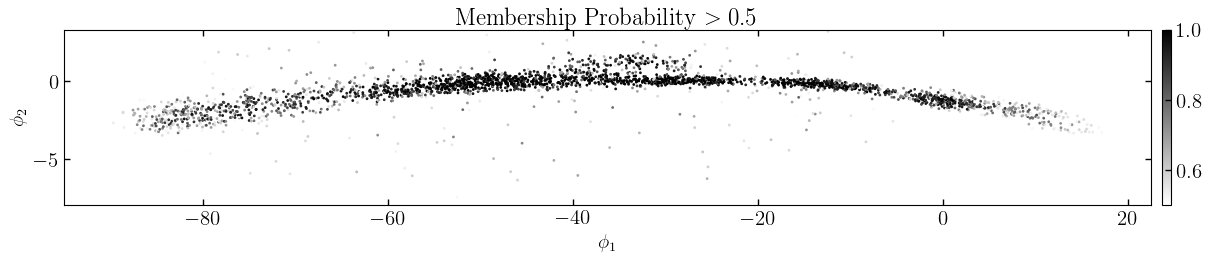

In [ ]:
# fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
# ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=1)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
# ax1.set_title(r'Membership Probability $> 0.5$')
# ax1.set_ylim(*phi2_lim)

# ax2.scatter(all_data_[memb_sel2]['phi1'], all_data_[memb_sel2]['phi2'], s=1)
# ax2.set_title(r'Membership Probability $> 0.75$')

# ax3.scatter(all_data_[memb_sel3]['phi1'], all_data_[memb_sel3]['phi2'], s=1)
# ax3.set_title(r'Membership Probability $> 0.9$')

# ax3.set_xlabel(r'$\phi_1$')
# plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], c=memb_prob[memb_sel1], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_ylim(*phi2_lim)
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

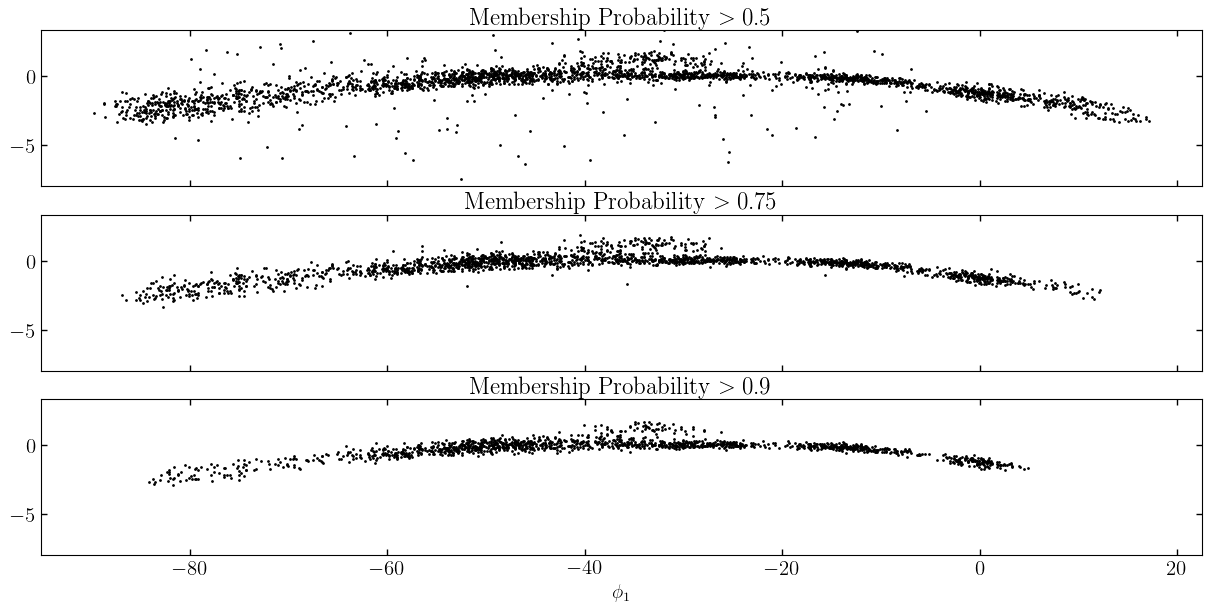

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel1&~bad_cmd_sel]['phi1'], all_data_[memb_sel1&~bad_cmd_sel]['phi2'], s=1)
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_ylim(*phi2_lim)

ax2.scatter(all_data_[memb_sel2&~bad_cmd_sel]['phi1'], all_data_[memb_sel2&~bad_cmd_sel]['phi2'], s=1)
ax2.set_title(r'Membership Probability $> 0.75$')

ax3.scatter(all_data_[memb_sel3&~bad_cmd_sel]['phi1'], all_data_[memb_sel3&~bad_cmd_sel]['phi2'], s=1)
ax3.set_title(r'Membership Probability $> 0.9$')

ax3.set_xlabel(r'$\phi_1$')
plt.show()

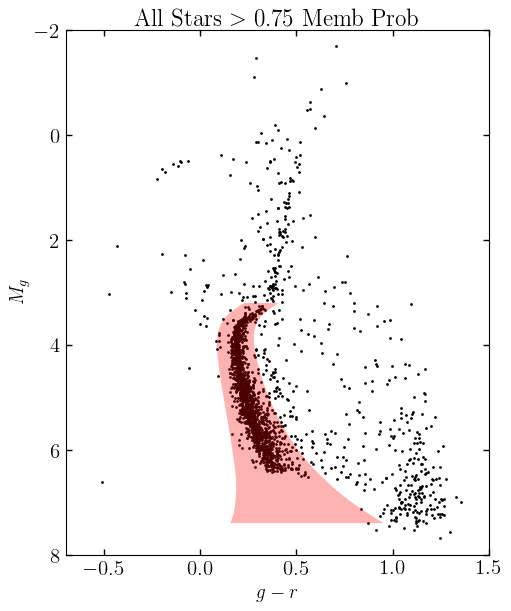

In [ ]:
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(all_data_[memb_sel2&~bad_cmd_sel]["phi1"]) - iso_obj.dist_mod


fig, ax1 = plt.subplots(1, 1, figsize=(5,6), sharey=True, sharex=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel2&~bad_cmd_sel]['g0'] - all_data_[memb_sel2&~bad_cmd_sel]['r0'], 
            all_data_[memb_sel2&~bad_cmd_sel]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
            c='k', s=1)
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
ax1.add_patch(cmd_patch)
ax1.set_title(r'All Stars $>0.75$ Memb Prob')

ax1.set_xlabel(r'$g-r$', fontsize=14)
ax1.set_ylabel(r'$M_g$', fontsize=14)

ax1.set_xlim(-0.7, 1.5)
ax1.set_ylim(8, -2)
plt.show()